# ME5413 Homework 3: Planning

## Task 0: Load the Map

In [1]:
# Import the NumPy library, which provides support for multi-dimensional arrays and numerical computations.
import numpy as np

# Import the imageio library (version 2), which allows reading and writing image files.
# we will use it to load map images such as the floor plan and occupancy grid.
import imageio.v2 as imageio

# This module provides functionality for plotting images, graphs, and annotations in Jupyter notebooks and scripts.
import matplotlib.pyplot as plt

# A Jupyter Notebook magic command to display matplotlib plots inline, directly below the code cell that produces them.
# This allows visual output (like map images and paths) to appear immediately after each cell without needing additional commands.
%matplotlib inline



Size of the map: (1000, 1000)
Occupied Cells: 823039
Free Cells: 176961


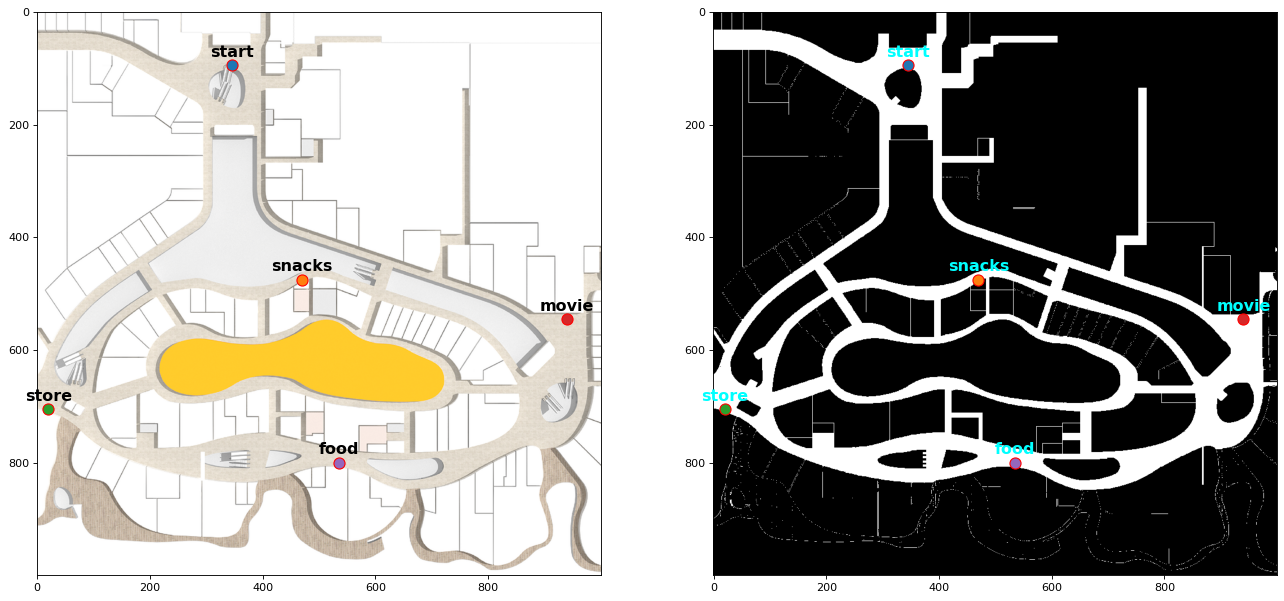

Cell start is free: True
Cell snacks is free: True
Cell store is free: True
Cell movie is free: True
Cell food is free: True


In [2]:
# Load the visual floor plan image of the map. This is used only for reference and visualization purposes.
# The image shows a colored layout of the environment (e.g., VivoCity level 2).
floor_plan = imageio.imread('./map/vivocity.png')

# Load the freespace (binary) map image, where:
# - pixel value 0 indicates an occupied cell (obstacle)
# - pixel value 255 indicates a free cell (traversable space)
grid_map_img = imageio.imread('./map/vivocity_freespace.png')

# Transpose the grid map to match the (x, y) orientation used in plotting and path planning.
# Image arrays are usually stored in (row, column) format, which corresponds to (y, x) in Cartesian space.
grid_map = grid_map_img.transpose()

# Print the shape of the transposed map, showing the number of columns (width) and rows (height).
print("Size of the map:", grid_map.shape)

# Count the number of occupied cells (value == 0), which represent obstacles.
print("Occupied Cells:", np.count_nonzero(grid_map == 0))

# Count the number of free cells (value == 255), which represent traversable space.
print("Free Cells:", np.count_nonzero(grid_map == 255))


# Define the resolution of the map.
# Each cell in the grid corresponds to a real-world square of 0.2 meters by 0.2 meters.
# This value is used later to convert from pixel distance to physical distance in meters.
MAP_RES = 0.2


# Define a dictionary containing named locations of interest on the map.
# The keys are logical names, and the values are coordinates [x, y] in pixel units.
# These points represent places the robot will visit or use as start/end points.
locations = {
    'start':  [345, 95],     
    'snacks': [470, 475],    
    'store':  [20, 705],     
    'movie':  [940, 545],    
    'food':   [535, 800],    
}


# Define a helper function that plots labeled location markers on a map.
# Arguments:
# - locations: dictionary of (label, [x, y]) points
# - color: text color for the label
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        # Plot a red circular marker at each location.
        plt.plot(locations[key][0], locations[key][1],
                 marker="o", markersize=10, markeredgecolor="red")
        
        # Annotate each point with its name slightly above the marker.
        plt.text(locations[key][0], locations[key][1] - 15,
                 s=key, fontsize='x-large', fontweight='bold',
                 c=color, ha='center')
    return


# Create a figure for displaying the map and marked points.
# Set the overall figure size and resolution (DPI).
plt.figure(figsize=(20, 10), dpi=80)

# First subplot: show the full-color floor plan with marked locations.
plt.subplot(1, 2, 1)
plt.imshow(floor_plan)              # Display the visual map
plot_locations(locations)           # Plot location markers in black

# Second subplot: show the binary occupancy grid (gray = obstacle, white = free).
plt.subplot(1, 2, 2)
plt.imshow(grid_map_img, cmap='gray')  # Show binary freespace image
plot_locations(locations, color='cyan')  # Plot markers in cyan for contrast

# Render the full figure (both subplots) with the marked locations.
plt.show()


# Iterate through all named locations to check if they are located in free space.
# This is important because path planning will fail if start/goal is inside an obstacle.
for key, value in locations.items():
    # Access the transposed grid to verify that the cell value is 255 (free)
    print(f"Cell {key} is free: {grid_map[value[0], value[1]] == 255}")


## Task 1

Obstacle inflation: 2 pixels


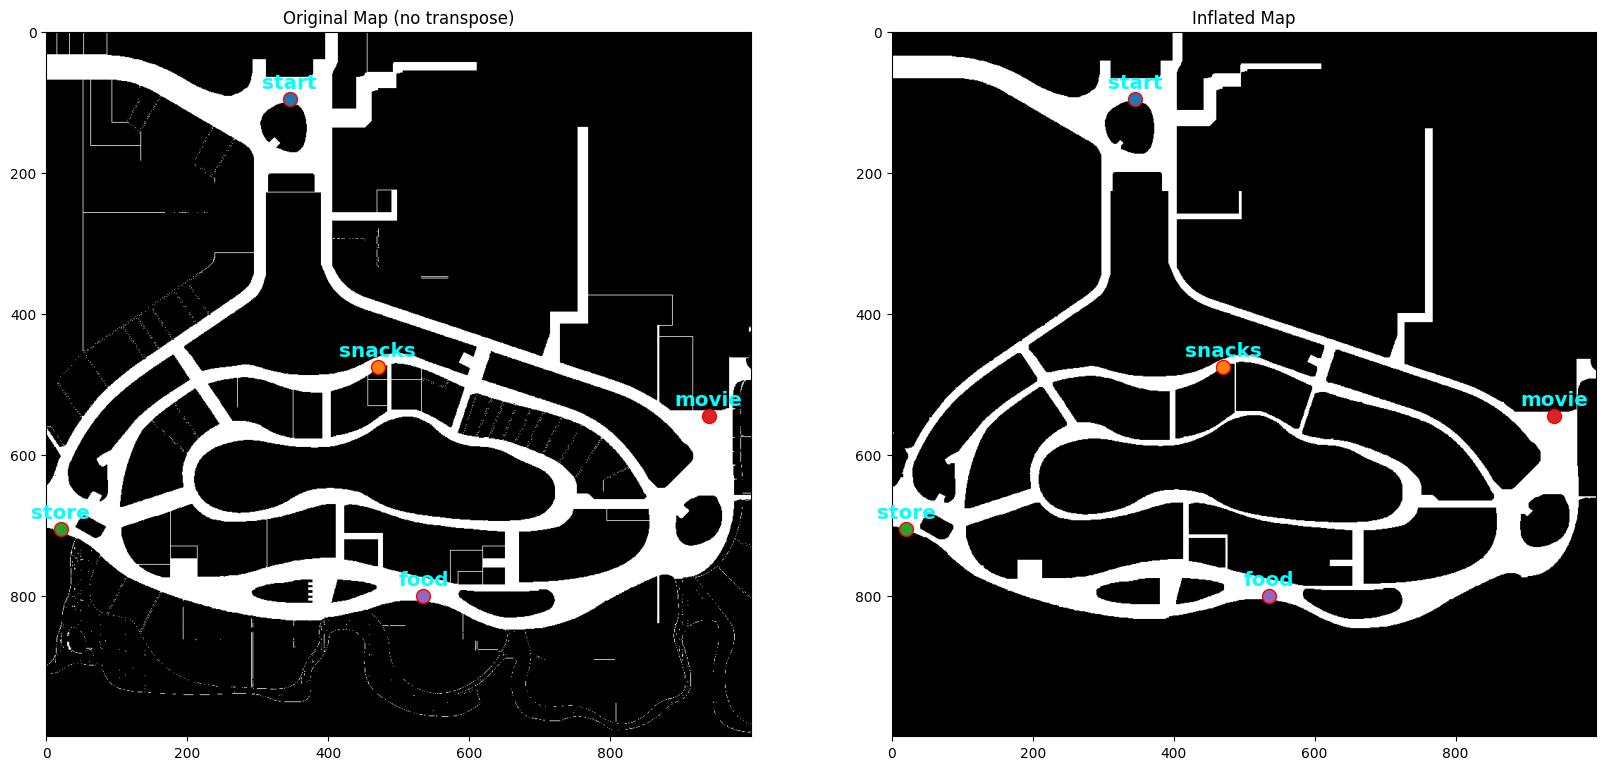

start: free
snacks: free
store: free
movie: free
food: free


In [3]:
# Import the binary_dilation function from SciPy.
# This function performs morphological dilation on binary images, which we use to inflate obstacles.
from scipy.ndimage import binary_dilation


# === Configuration parameters for obstacle inflation ===

# Define the robot's physical radius in meters.
# This is used to determine how much we need to "grow" obstacles to account for the robot's size.
ROBOT_RADIUS = 0.3  # meters

# Define the map resolution: how many meters one grid cell represents.
# This value is used to convert physical units into pixel units for image-based map processing.
MAP_RES = 0.2  # meters per pixel


# === Coordinate consistency correction ===

# grid_map.transpose() was used earlier to adjust orientation,
# but for obstacle inflation we must keep the image in its original orientation.
# Transposing again would misalign the axes and cause plotting and access errors.
# Therefore, we copy the original binary freespace image (grid_map_img) directly without transposing.
grid_map_corrected = grid_map_img.copy()  # Maintain original image orientation


# === Obstacle Inflation Function ===

# Define a function to inflate obstacles in the map using binary dilation.
# This process grows all obstacles outward by a radius equal to the robot's footprint.
# This ensures that paths planned through the map will not result in collisions.

def inflate_obstacles(grid_map, inflation_radius_m, map_res):
    # Convert the inflation radius from meters to pixels using the map resolution.
    inflation_radius_px = int(np.ceil(inflation_radius_m / map_res))

    # Print the calculated inflation radius for verification.
    print(f"Obstacle inflation: {inflation_radius_px} pixels")

    # Create a binary mask where obstacles (value 0) are marked as True.
    obstacle_mask = grid_map == 0

    # Define a square structuring element (kernel) for dilation.
    # The kernel size is determined by the inflation radius in pixels.
    struct_elem = np.ones((2 * inflation_radius_px + 1, 2 * inflation_radius_px + 1))

    # Apply binary dilation: expand all obstacle regions by the structuring element.
    # This creates a buffer zone around obstacles, treating near cells as unsafe.
    inflated_mask = binary_dilation(obstacle_mask, structure=struct_elem)

    # Create the inflated grid map: set dilated areas to 0 (obstacle), others to 255 (free).
    # Convert to 8-bit unsigned integer image format.
    inflated_grid = np.where(inflated_mask, 0, 255).astype(np.uint8)

    # Return the inflated occupancy grid
    return inflated_grid


# === Perform obstacle inflation ===

# Apply the inflation function to the corrected grid map using the robot's radius and map resolution.
# This gives us a new map where obstacles are safely buffered for path planning.
inflated_grid_map = inflate_obstacles(grid_map_corrected, ROBOT_RADIUS, MAP_RES)


# === Visualization: Compare Original and Inflated Maps ===

# Create a side-by-side visualization to compare the original map and the inflated one.
plt.figure(figsize=(20, 10))

# Left: original freespace map (before inflation)
plt.subplot(1, 2, 1)
plt.title("Original Map (no transpose)")
plt.imshow(grid_map_corrected, cmap='gray')  # Show original binary map
plot_locations(locations, color='cyan')      # Overlay location markers

# Right: inflated map with enlarged obstacles
plt.subplot(1, 2, 2)
plt.title("Inflated Map")
plt.imshow(inflated_grid_map, cmap='gray')   # Show inflated map
plot_locations(locations, color='cyan')      # Overlay same locations for comparison

# Display both plots
plt.show()


# === Location Availability Check ===

# After inflation, some previously accessible locations may now lie inside inflated obstacles.
# We check each predefined location and report whether it is still free or now blocked.

for key, value in locations.items():
    x, y = value  # Coordinates of the location (x, y)
    
    # Access the inflated grid map at the location.
    # If the value is 255, the cell is free. Otherwise, it is considered blocked.
    status = "free" if inflated_grid_map[y, x] == 255 else "BLOCKED (after inflation)"
    
    # Print the result for each location.
    print(f"{key}: {status}")


In [4]:
import heapq        # Provides a priority queue implementation (min-heap), required for A* open set.
import time         # Used to measure the runtime of the algorithm.

# Heuristic function used to estimate the remaining cost from a given node to the goal.
# This is the core of A*'s informed search capability.
# We use Euclidean distance, which is appropriate when diagonal movement is allowed.
def heuristic(a, b):
    return np.linalg.norm(np.array(a) - np.array(b))


# Returns all valid neighboring positions around the current cell, along with their movement cost.
# - 4-connected (N, S, E, W) neighbors have cost 0.2 (horizontal/vertical).
# - 8-connected (diagonals) neighbors have cost ~0.282 (approx. sqrt(2) * 0.2).
# The function filters out neighbors that are outside the grid bounds or lie on obstacles.
def get_neighbors(pos, grid):
    neighbors = []

    # Define movement directions: 4 cardinal + 4 diagonals
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1),      # up, down, left, right
                  (-1, -1), (-1, 1), (1, -1), (1, 1)]    # diagonal directions

    for dx, dy in directions:
        # Compute the neighbor coordinates (y, x)
        nx, ny = pos[0] + dx, pos[1] + dy

        # Ensure the neighbor is within the grid bounds
        if 0 <= nx < grid.shape[0] and 0 <= ny < grid.shape[1]:
            # Check if the cell is free space (255), not an obstacle
            if grid[nx, ny] == 255:
                # Diagonal move has a higher cost (Pythagorean), straight move is cheaper
                move_cost = 0.282 if dx != 0 and dy != 0 else 0.2
                neighbors.append(((nx, ny), move_cost))

    return neighbors


# Main A* search function for finding the shortest path from 'start' to 'goal' on a given grid.
def astar(grid, start, goal):
    # Record the starting time for performance measurement
    start_time = time.time()

    # Convert (x, y) coordinates to (y, x) to match NumPy row-major indexing
    start = tuple(reversed(start))
    goal = tuple(reversed(goal))

    # Initialize the open set as a priority queue (min-heap), sorted by f = g + h
    open_set = []
    heapq.heappush(open_set, (0 + heuristic(start, goal), 0, start))  # (f, g, node)

    # Dictionary to store the optimal previous node for each visited node
    came_from = {}

    # Dictionary to store the lowest cost to reach each node from the start
    cost_so_far = {start: 0}

    # Set to keep track of all nodes that have been visited (expanded)
    visited = set()

    # Main A* loop: runs until all options are exhausted or goal is found
    while open_set:
        _, g, current = heapq.heappop(open_set)  # Pop the node with lowest f-score
        visited.add(current)                     # Mark the node as visited

        # Goal test: if we've reached the destination, exit the loop
        if current == goal:
            break

        # Explore all valid neighboring cells of the current node
        for neighbor, move_cost in get_neighbors(current, grid):
            new_cost = cost_so_far[current] + move_cost

            # If the neighbor is unvisited or a cheaper path is found, update cost and parent
            if neighbor not in cost_so_far or new_cost < cost_so_far[neighbor]:
                cost_so_far[neighbor] = new_cost
                priority = new_cost + heuristic(neighbor, goal)  # f = g + h
                heapq.heappush(open_set, (priority, new_cost, neighbor))
                came_from[neighbor] = current


    # === Path reconstruction ===

    # Initialize an empty list to store the reconstructed path from goal to start
    path = []
    current = goal

    # Backtrack from goal to start using the 'came_from' dictionary
    # If the goal was unreachable, this will produce only the start node
    while current != start:
        path.append(current)
        current = came_from.get(current, start)  # Default to start if no parent is found

    # Add the start point and reverse the list to get the correct order
    path.append(start)
    path.reverse()


    # Compute the total physical distance (in meters) by scaling g-cost
    total_distance = cost_so_far.get(goal, float('inf')) * MAP_RES

    # Compute the runtime duration in seconds
    runtime = time.time() - start_time

    # Return:
    # - path: a list of (y, x) grid cells from start to goal
    # - total_distance: path length in meters
    # - visited: set of explored nodes (can be visualized)
    # - runtime: total time taken to compute the path
    return path, total_distance, visited, runtime


In [5]:
# This function visualizes a path on a 2D occupancy grid map.
# It shows:
#   - the grid itself (obstacles and free space),
#   - optionally the visited nodes (if provided),
#   - the final path in red,
#   - and the start/goal locations as labeled markers.
# This is useful for debugging and evaluating path-planning algorithms such as A*.

def plot_path_on_map(grid, path, visited=None, start=None, goal=None, title="A* Path"):
    
    # Create a new figure with fixed size for consistent display.
    # (10, 10) inches provides a square figure suitable for square-shaped maps.
    plt.figure(figsize=(10, 10))

    # Display the grid map as a grayscale image.
    # 'cmap=gray' means: 0 = black (obstacle), 255 = white (free space).
    plt.imshow(grid, cmap='gray')

    # If a set of visited nodes is provided (e.g., from A* exploration),
    # then plot all visited cells using very small light blue dots.
    # These help visualize how the search algorithm explored the map.
    if visited:
        for p in visited:
            # Coordinates in 'p' are in (y, x) format to match the image coordinate system.
            plt.plot(p[1], p[0], '.', color='lightblue', markersize=1)

    # Convert the final path from a list of (y, x) tuples into a NumPy array for easy slicing.
    path = np.array(path)

    # Draw the final path as a continuous red line connecting the path points in order.
    # path[:,1] = x-axis values, path[:,0] = y-axis values (since image axes are [row, column])
    plt.plot(path[:,1], path[:,0], color='red', linewidth=2, label='Path')

    # If a start point is provided, mark it with a green circle.
    # Note that start is in (x, y) format, so start[0] = x and start[1] = y.
    if start:
        plt.plot(start[0], start[1], 'go', label='Start')  # 'g' = green, 'o' = circle marker

    # If a goal point is provided, mark it with a blue circle.
    # Also uses (x, y) format consistent with other plotting functions.
    if goal:
        plt.plot(goal[0], goal[1], 'bo', label='Goal')     # 'b' = blue, 'o' = circle marker

    # Add a legend to indicate what the colored elements represent:
    # Start point, Goal point, Path line.
    plt.legend()

    # Set the title of the plot, which is useful when displaying multiple path comparisons.
    # Default title is "A* Path", but this can be customized when the function is called.
    plt.title(title)

    # Display the final plot in the notebook or script output.
    plt.show()



 path：start ➜ snacks
Total Distance: 28.99 m
Visited Cells: 4074
Runtime: 0.2613 s


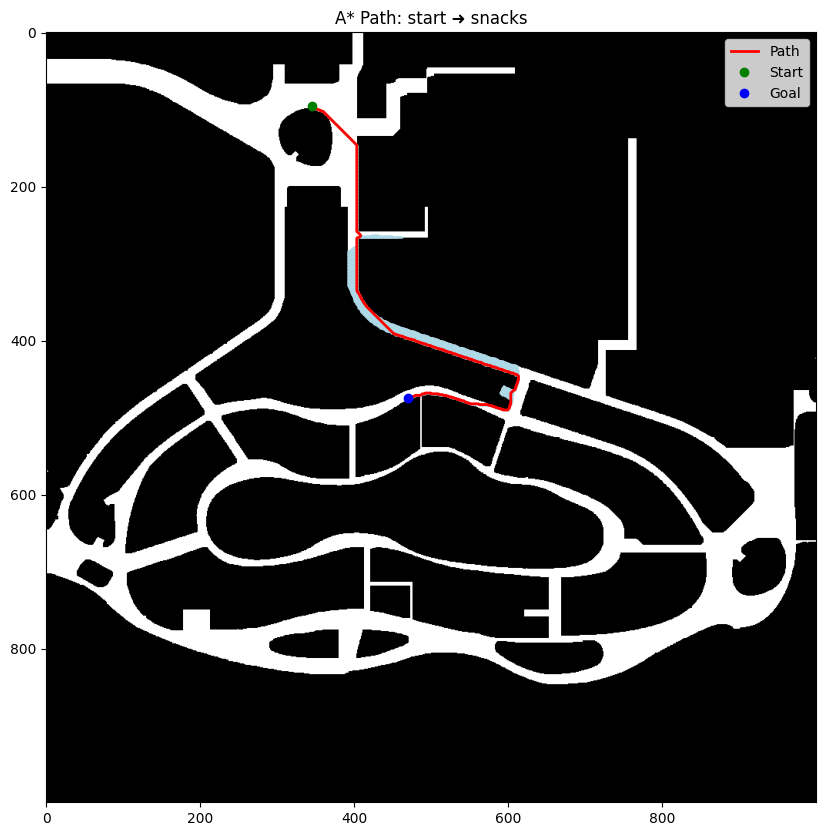

<Figure size 640x480 with 0 Axes>


 path：start ➜ store
Total Distance: 32.04 m
Visited Cells: 695
Runtime: 0.0288 s


<Figure size 640x480 with 0 Axes>

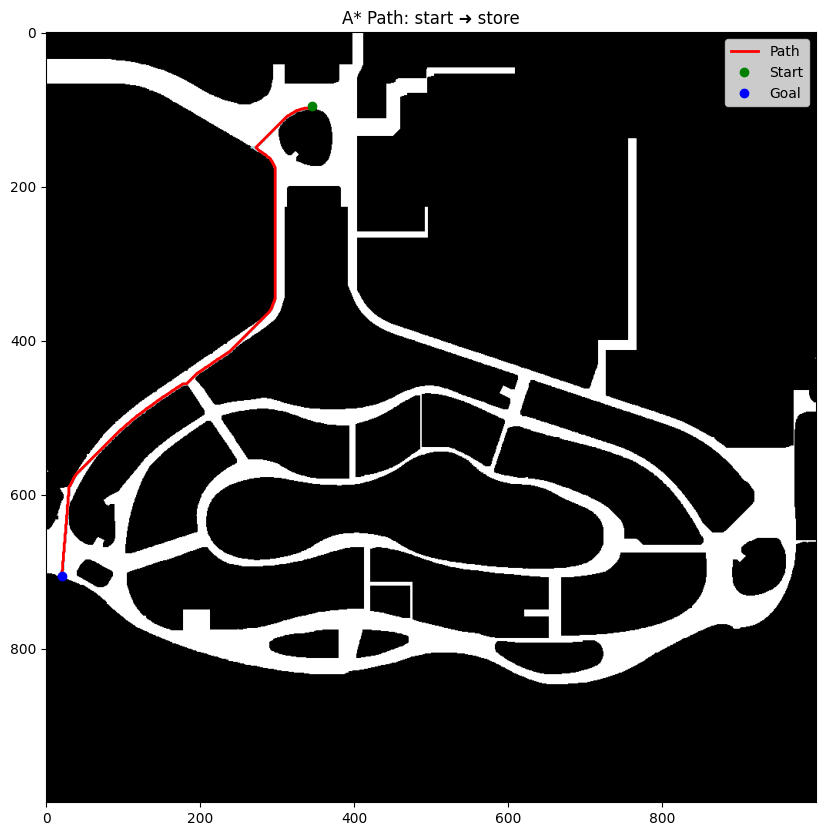

<Figure size 640x480 with 0 Axes>


 path：start ➜ movie
Total Distance: 36.14 m
Visited Cells: 1659
Runtime: 0.1535 s


<Figure size 640x480 with 0 Axes>

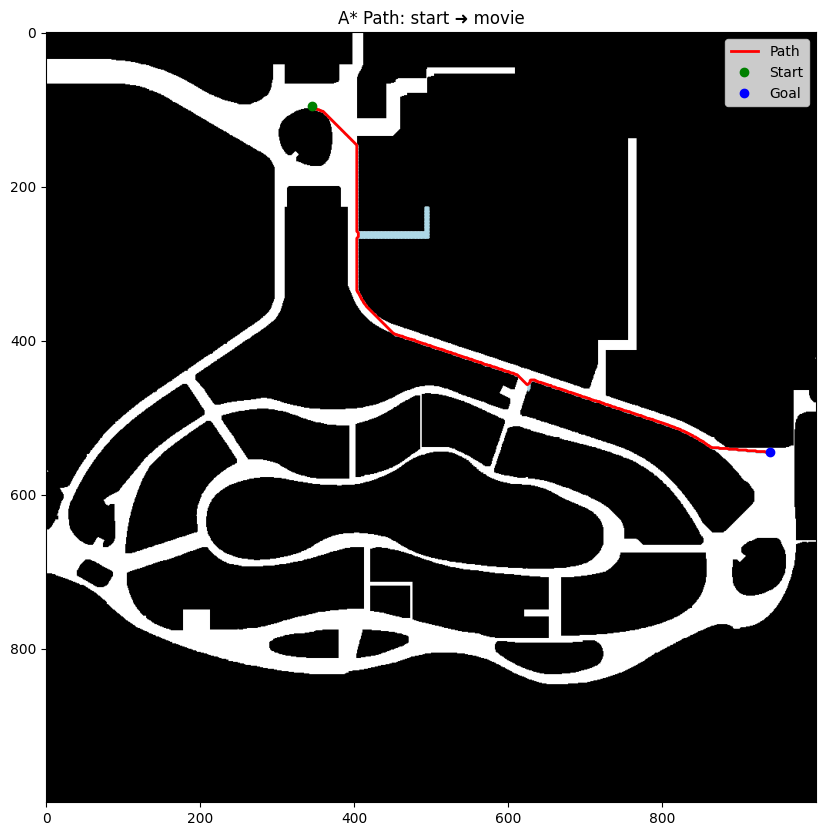

<Figure size 640x480 with 0 Axes>


 path：start ➜ food
Total Distance: 46.72 m
Visited Cells: 4302
Runtime: 0.4371 s


<Figure size 640x480 with 0 Axes>

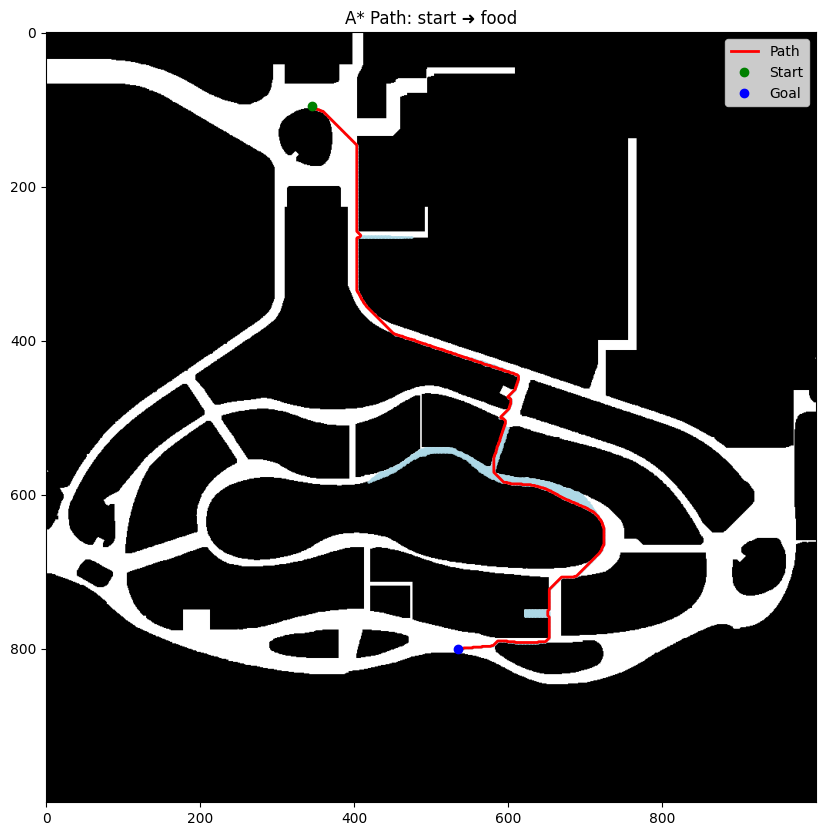

<Figure size 640x480 with 0 Axes>


 path：snacks ➜ store
Total Distance: 24.80 m
Visited Cells: 539
Runtime: 0.0225 s


<Figure size 640x480 with 0 Axes>

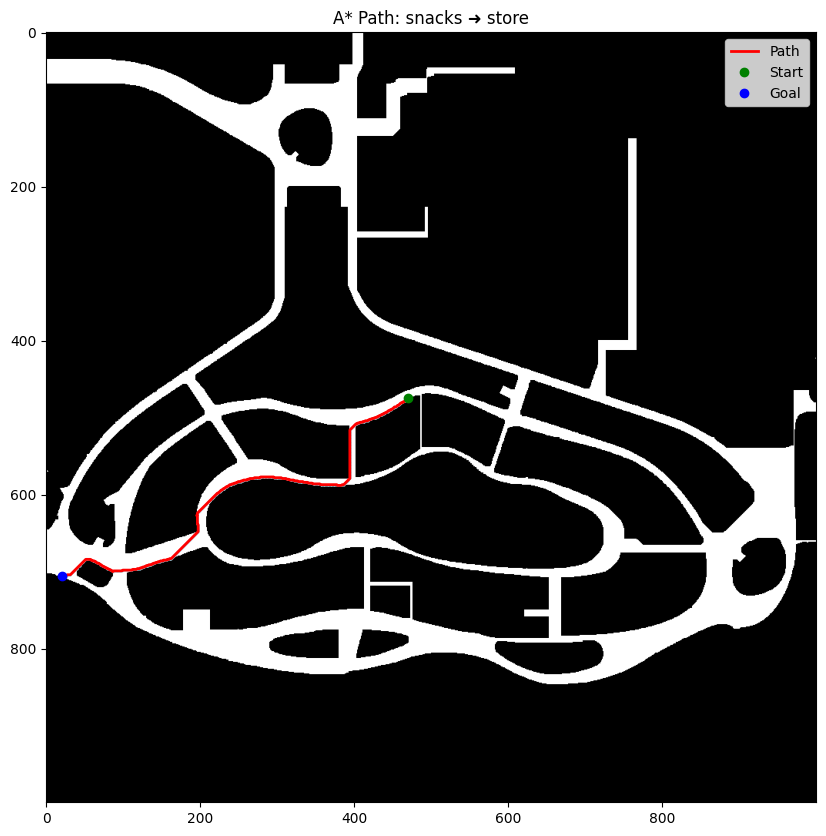

<Figure size 640x480 with 0 Axes>


 path：snacks ➜ movie
Total Distance: 25.07 m
Visited Cells: 1335
Runtime: 0.1046 s


<Figure size 640x480 with 0 Axes>

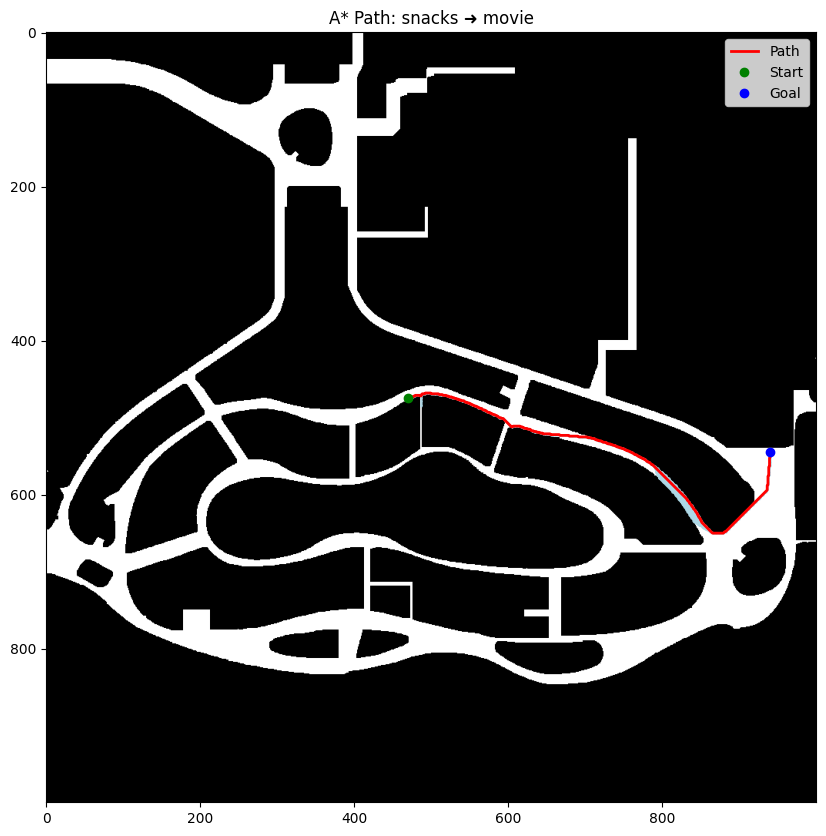

<Figure size 640x480 with 0 Axes>


 path：snacks ➜ food
Total Distance: 27.14 m
Visited Cells: 4708
Runtime: 0.4543 s


<Figure size 640x480 with 0 Axes>

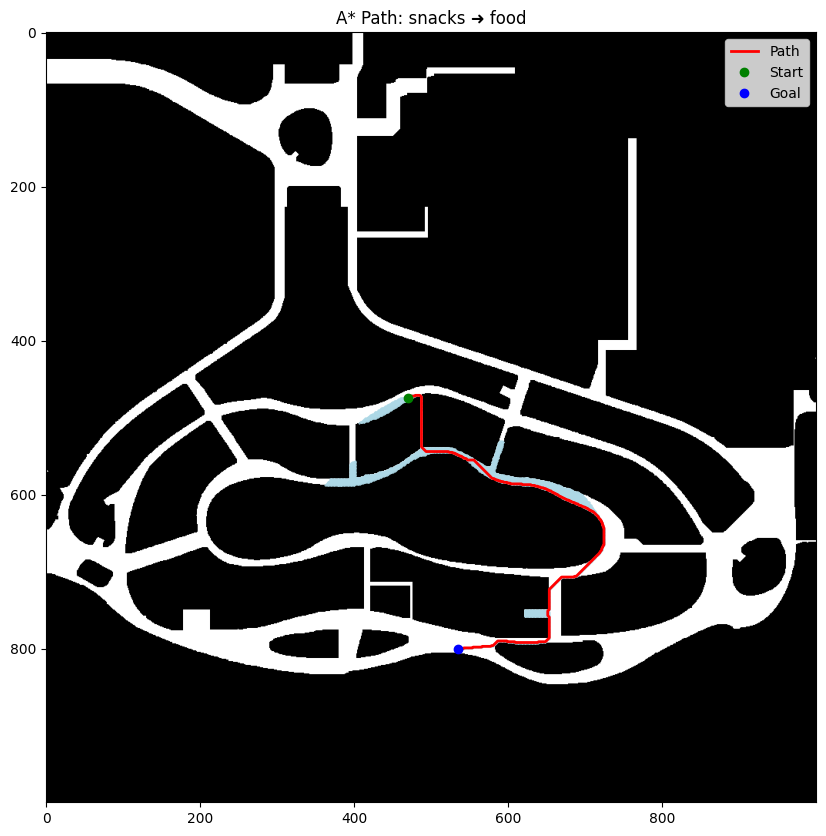

<Figure size 640x480 with 0 Axes>


 path：store ➜ movie
Total Distance: 51.42 m
Visited Cells: 1903
Runtime: 0.0900 s


<Figure size 640x480 with 0 Axes>

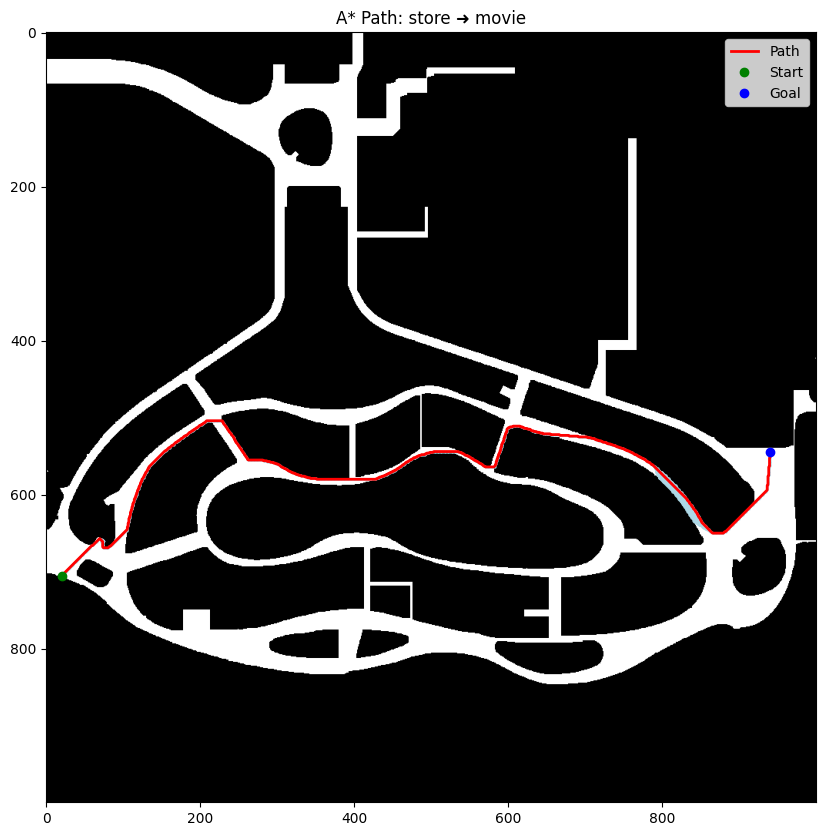

<Figure size 640x480 with 0 Axes>


 path：store ➜ food
Total Distance: 23.04 m
Visited Cells: 541
Runtime: 0.0189 s


<Figure size 640x480 with 0 Axes>

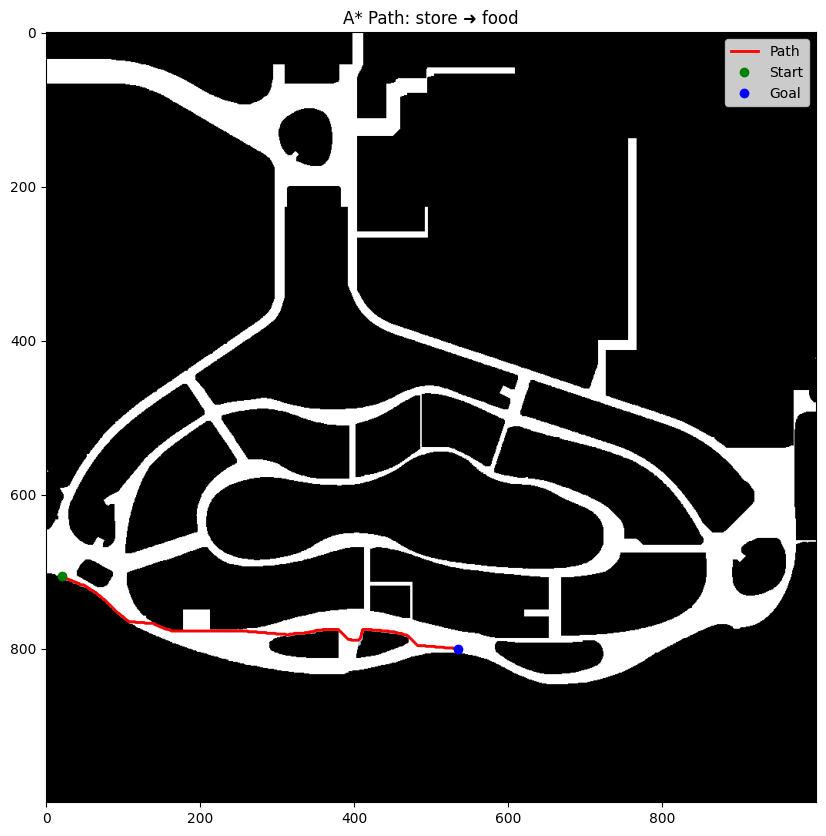

<Figure size 640x480 with 0 Axes>


 path：movie ➜ food
Total Distance: 40.37 m
Visited Cells: 5509
Runtime: 0.4775 s


<Figure size 640x480 with 0 Axes>

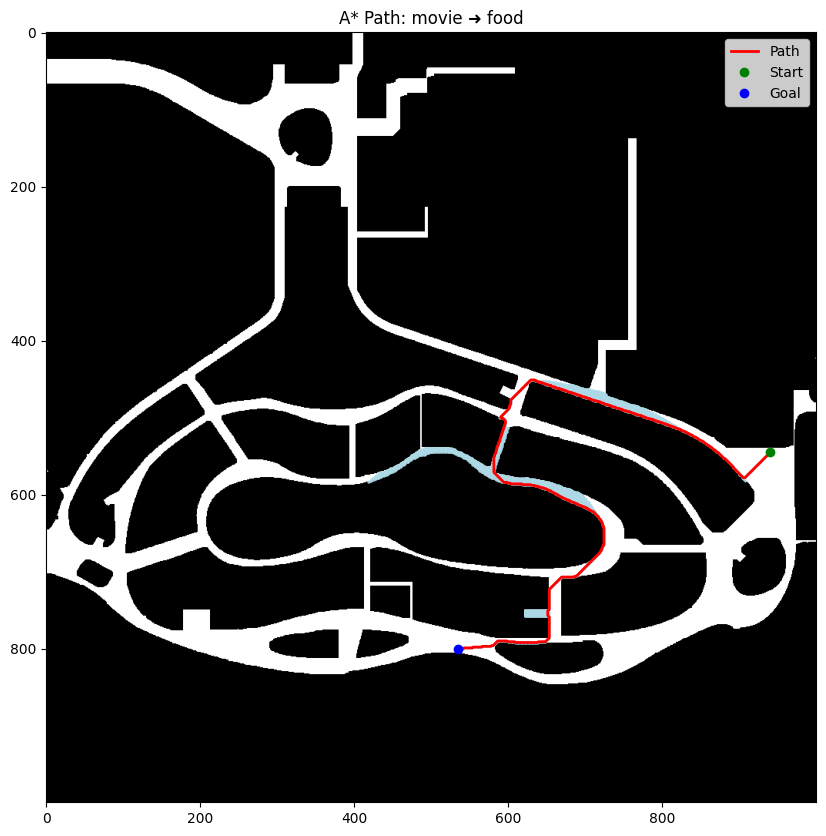

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [33]:
# Import the combinations function from the itertools module.
# It allows us to generate all unique unordered pairs of elements (e.g., (A, B), (A, C), ...).
from itertools import combinations

# Import display from IPython to explicitly render matplotlib figures inline in Jupyter Notebook.
# This ensures each plot is shown individually without being overwritten by subsequent figures.
from IPython.display import display


# Extract all location names (keys) from the dictionary and store them in a list.
# This list will be used to generate all pairwise combinations for path planning.
location_names = list(locations.keys())


# Create a dictionary to store computed distances between every pair of locations.
# Each entry will store the shortest distance (in meters) between two named locations.
distance_table = {}

a_star_runtime_dict = {}
a_star_visited_dict = {}
# Dictionaries to store RRT performance metrics
rrt_runtime_dict = {}
rrt_visited_dict = {}

# Iterate over all unique, unordered combinations of two locations.
# For example, if there are 5 locations, this will compute (5 choose 2) = 10 combinations.
for loc1, loc2 in combinations(location_names, 2):
    
    # Retrieve the coordinates of the two locations using their names as keys.
    start = locations[loc1]
    goal = locations[loc2]

    # Print the route currently being computed for logging and clarity.
    print(f"\n path：{loc1} ➜ {loc2}")




    # Call the A* algorithm to compute the shortest path from start to goal.
    # Inputs:
    #   - inflated_grid_map: the occupancy map with obstacle inflation
    #   - start, goal: coordinate pairs (x, y) of the two locations
    # Outputs:
    #   - path: list of waypoints (y, x) from start to goal
    #   - distance: total path length in meters
    #   - visited: all explored nodes during search
    #   - runtime: time taken by A* to find the path (in seconds)
    path, distance, visited, runtime = astar(inflated_grid_map, start, goal)
    a_star_runtime_dict[(loc1, loc2)] = runtime
    a_star_visited_dict[(loc1, loc2)] = len(visited)

    a_star_runtime_dict[(loc2, loc1)] = runtime
    a_star_visited_dict[(loc2, loc1)] = len(visited)

    


    # Save the computed distance in the dictionary using both (loc1, loc2) and (loc2, loc1) keys.
    # This creates a symmetric lookup for later use, since the map is undirected.
    distance_table[(loc1, loc2)] = distance
    distance_table[(loc2, loc1)] = distance


    # Print summary statistics for the current path:
    # - total distance traveled
    # - number of visited cells (search effort)
    # - time taken to find the path
    print(f"Total Distance: {distance:.2f} m")
    print(f"Visited Cells: {len(visited)}")
    print(f"Runtime: {runtime:.4f} s")


    # Visualize the computed path using the custom plotting function defined earlier.
    # This shows:
    #   - The inflated grid map as background
    #   - Visited nodes in light blue
    #   - The path in red
    #   - Start and goal markers
    plot_path_on_map(
        inflated_grid_map,
        path,
        visited,
        start=start,
        goal=goal,
        title=f"A* Path: {loc1} ➜ {loc2}"  # Custom title for each pair
    )

    # Force the current matplotlib figure to display immediately.
    # Without this, some Jupyter environments may skip or collapse figures when looping.
    display(plt.gcf())


In [23]:
# Import standard Python libraries
import random   # Used for uniform random sampling (for RRT exploration)
import math     # Provides access to mathematical functions like sqrt, hypot, etc.

# Define a class to represent a node in the RRT tree
# Each node stores its position (in (y, x) format) and a reference to its parent node
class Node:
    def __init__(self, pos, parent=None):
        self.pos = pos          # Node position on the grid as a (y, x) tuple
        self.parent = parent    # Reference to the parent Node (used for backtracking the path)


# Define the RRT path planning function
def rrt(grid, start, goal, step_size=10, max_iter=5000, goal_threshold=10):
    import time  # Used to measure runtime performance
    start_time = time.time()

    # Get the dimensions of the grid (height = rows, width = columns)
    height, width = grid.shape

    # Convert start and goal coordinates from (x, y) to (y, x)
    # This matches the row-major format used by NumPy images
    start = tuple(reversed(start))
    goal = tuple(reversed(goal))

    # Initialize the tree with the start node
    tree = [Node(start)]

    # Track all visited nodes for optional visualization
    visited = set()

    # Initialize the final path list
    path = []

    # Define a helper function to check whether a point is in free space
    def is_free(p):
        y, x = p
        # The cell must be within grid bounds and marked as free (value 255)
        return 0 <= y < height and 0 <= x < width and grid[y, x] == 255

    # Compute Euclidean distance between two points
    def distance(p1, p2):
        return np.linalg.norm(np.array(p1) - np.array(p2))

    # Compute a new point that moves from from_pos toward to_pos by at most step_size
    def steer(from_pos, to_pos):
        vec = np.array(to_pos) - np.array(from_pos)
        dist = np.linalg.norm(vec)
        if dist == 0:
            return from_pos
        # Normalize vector and scale by step_size or actual distance (whichever is smaller)
        vec = (vec / dist) * min(step_size, dist)
        new_pos = tuple((np.array(from_pos) + vec).astype(int))  # round and convert to int grid cell
        return new_pos


    # Main loop to grow the tree up to max_iter times
    for _ in range(max_iter):
        # === 1. Sample a random free node in the environment ===
        x_rand = (random.randint(0, height - 1), random.randint(0, width - 1))

        # === 2. Find the nearest node in the tree to the sampled point ===
        nearest = min(tree, key=lambda node: distance(node.pos, x_rand))

        # === 3. Attempt to steer from the nearest node toward the random point ===
        x_new = steer(nearest.pos, x_rand)

        # If the new position is not in free space, discard it and continue
        if not is_free(x_new):
            continue

        # Create a new node with its parent being the nearest node
        new_node = Node(x_new, nearest)

        # Add this new node to the tree and mark its position as visited
        tree.append(new_node)
        visited.add(x_new)

        # === 4. Goal check: if we are close enough to the goal, stop and build the path ===
        if distance(x_new, goal) < goal_threshold:
            # Connect the final node to the actual goal point
            goal_node = Node(goal, new_node)

            # Backtrack from the goal node to the start by following parent links
            current = goal_node
            while current:
                path.append(current.pos)
                current = current.parent

            # Reverse the path so it starts at the start node
            path.reverse()
            break


    # === Compute total distance along the found path ===
    total_distance = 0
    for i in range(1, len(path)):
        total_distance += distance(path[i - 1], path[i]) * MAP_RES

    # Compute total runtime for this planning attempt
    runtime = time.time() - start_time

    # Return the result:
    # - path: list of grid coordinates from start to goal
    # - total_distance: real-world distance (in meters)
    # - visited: all nodes expanded (for visualization)
    # - runtime: time in seconds
    return path, total_distance, visited, runtime


Running RRT planning for all location pairs...


Planning path: start ➜ snacks
Path found! Distance: 155.24 m, Time: 55.6964 s
Visited nodes: 1191


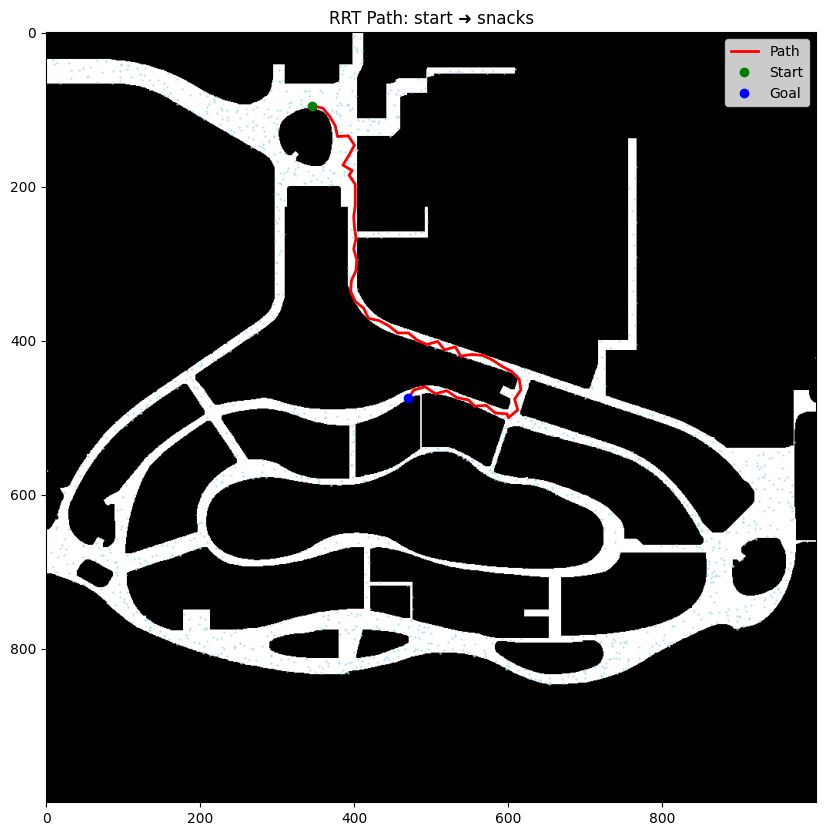

<Figure size 640x480 with 0 Axes>


Planning path: start ➜ store
Path found! Distance: 403.57 m, Time: 13.8701 s
Visited nodes: 590


<Figure size 640x480 with 0 Axes>

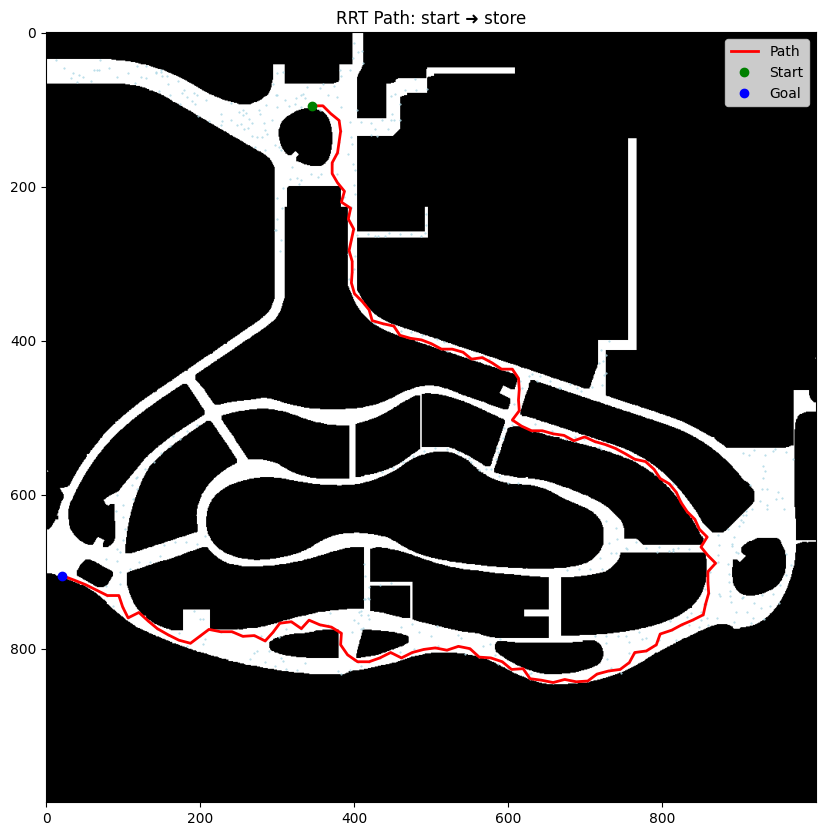

<Figure size 640x480 with 0 Axes>


Planning path: start ➜ movie
Path found! Distance: 317.92 m, Time: 19.0780 s
Visited nodes: 728


<Figure size 640x480 with 0 Axes>

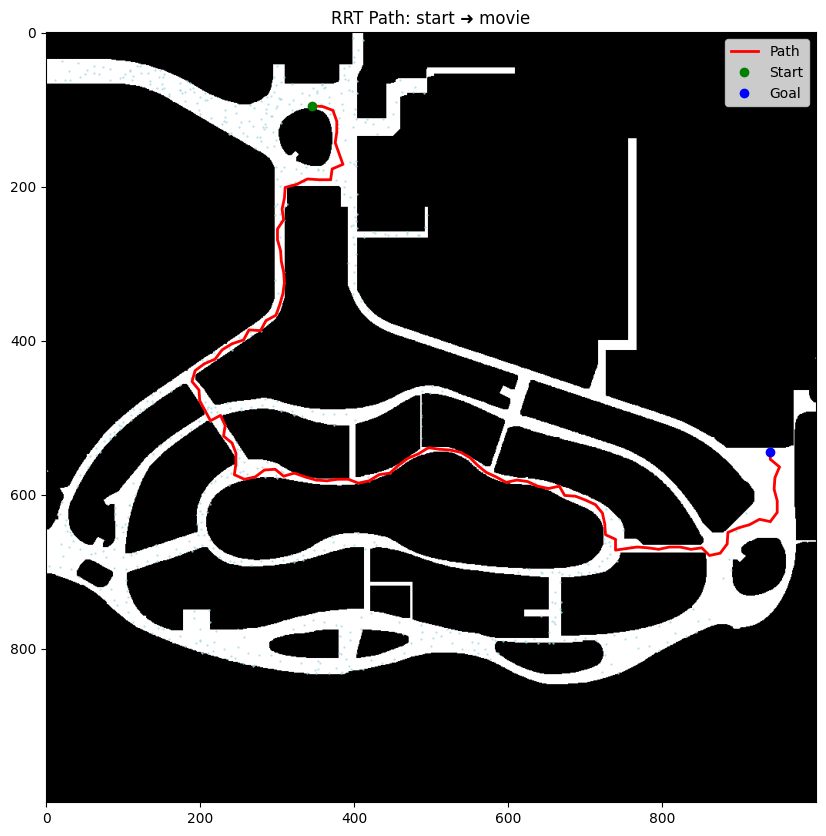

<Figure size 640x480 with 0 Axes>


Planning path: start ➜ food
Path found! Distance: 272.20 m, Time: 7.8283 s
Visited nodes: 425


<Figure size 640x480 with 0 Axes>

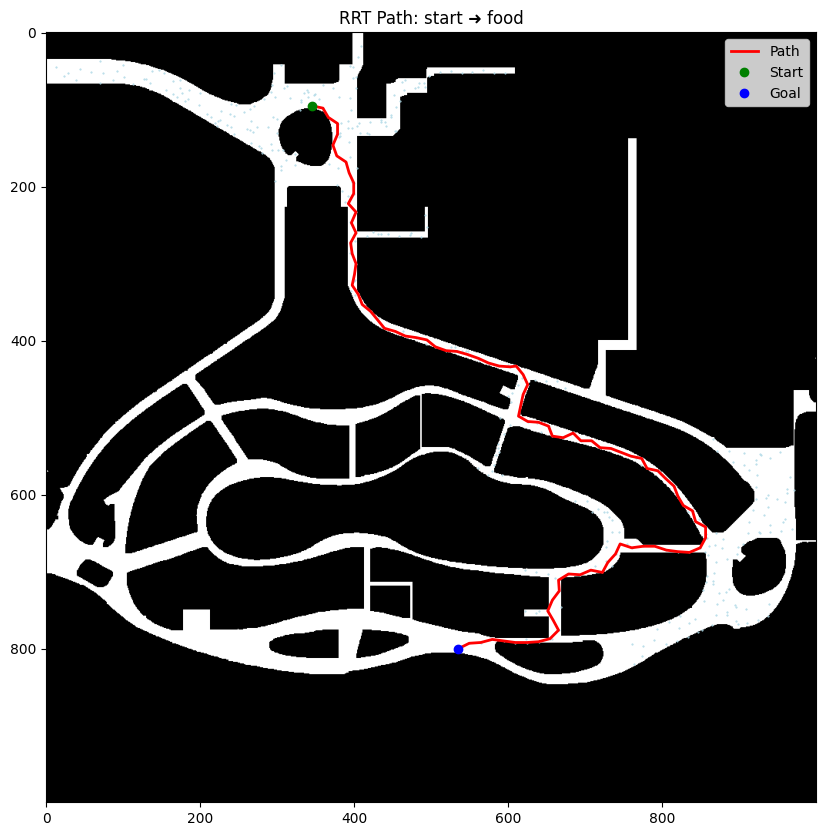

<Figure size 640x480 with 0 Axes>


Planning path: snacks ➜ store
Path found! Distance: 139.01 m, Time: 6.9188 s
Visited nodes: 419


<Figure size 640x480 with 0 Axes>

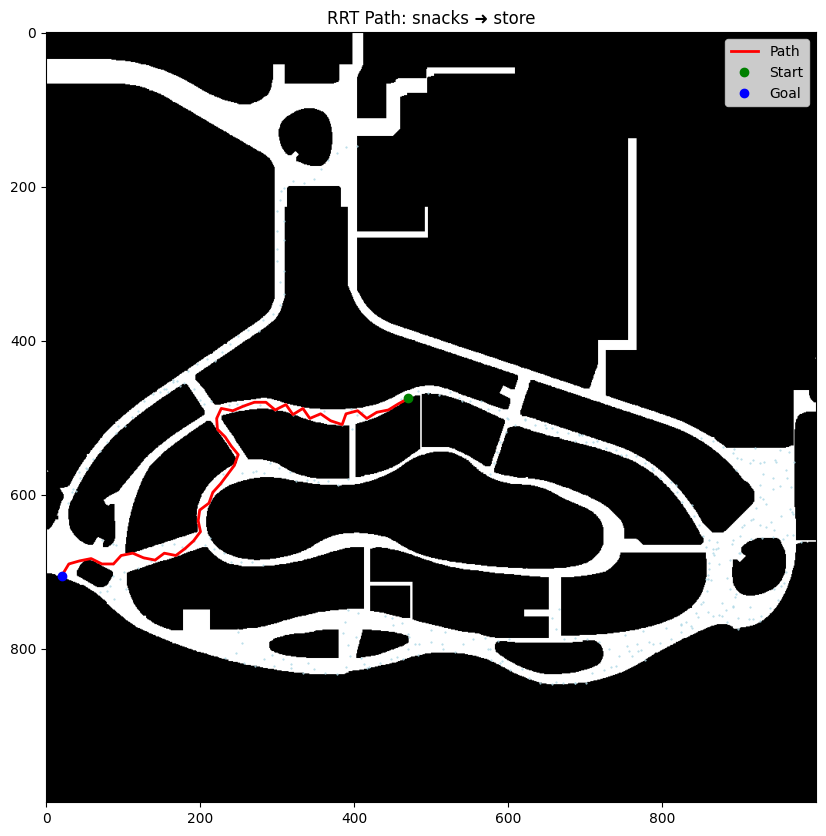

<Figure size 640x480 with 0 Axes>


Planning path: snacks ➜ movie
Path found! Distance: 130.50 m, Time: 0.6110 s
Visited nodes: 118


<Figure size 640x480 with 0 Axes>

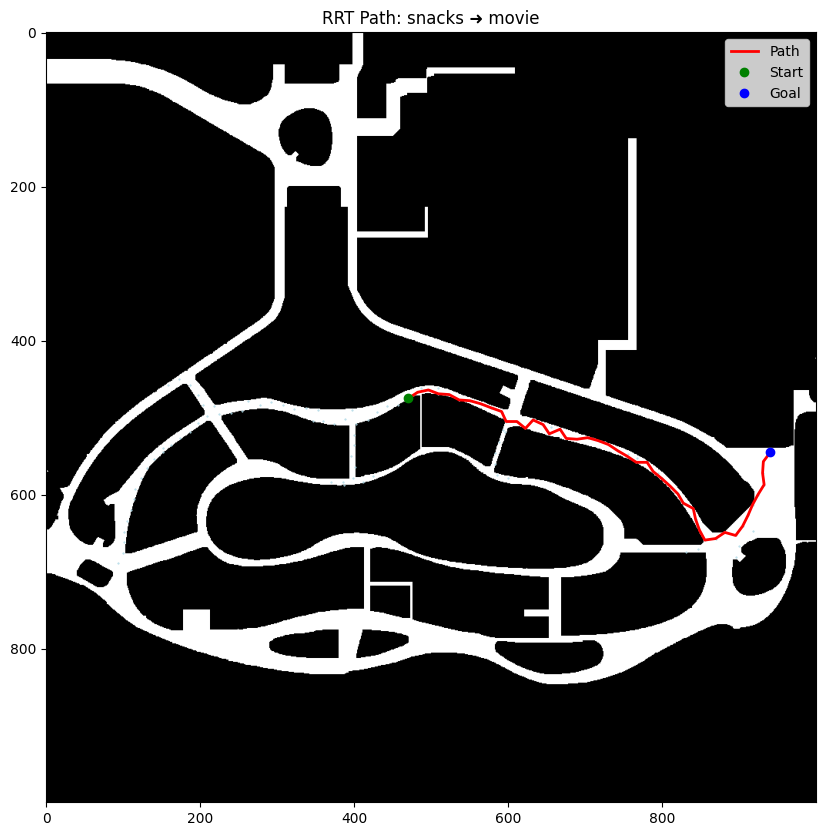

<Figure size 640x480 with 0 Axes>


Planning path: snacks ➜ food
Path found! Distance: 205.53 m, Time: 2.4363 s
Visited nodes: 282


<Figure size 640x480 with 0 Axes>

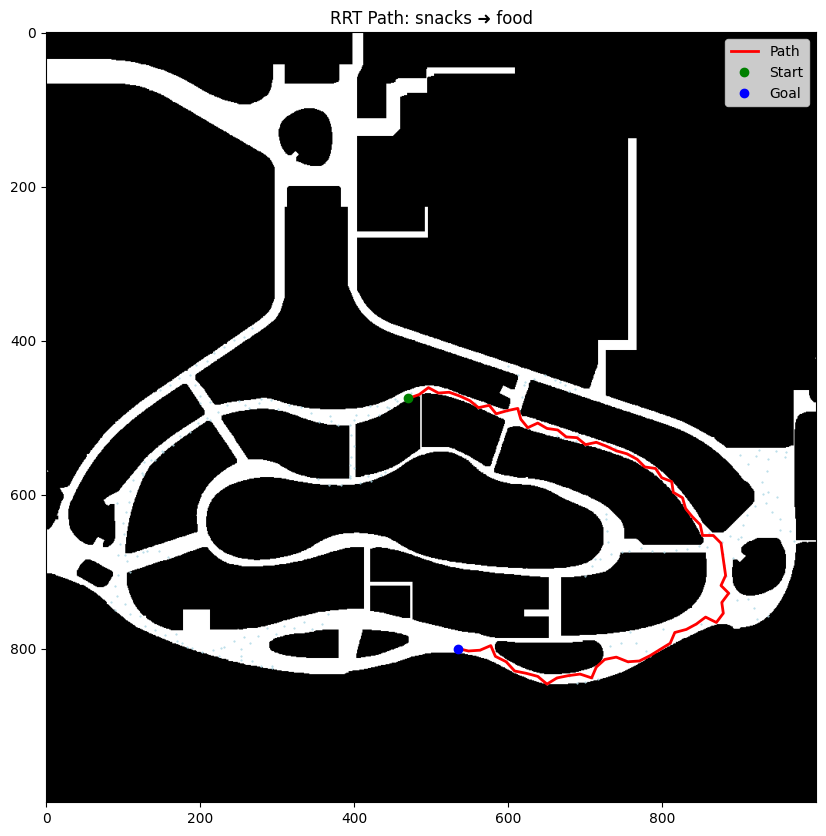

<Figure size 640x480 with 0 Axes>


Planning path: store ➜ movie
Path found! Distance: 229.35 m, Time: 1.8919 s
Visited nodes: 286


<Figure size 640x480 with 0 Axes>

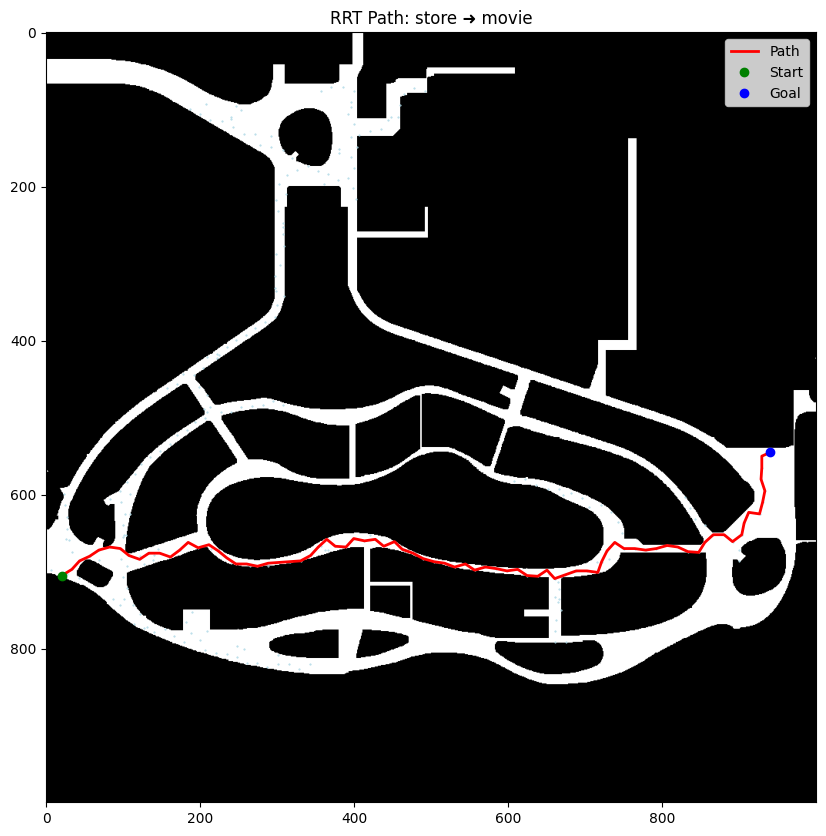

<Figure size 640x480 with 0 Axes>


Planning path: store ➜ food
Path found! Distance: 121.97 m, Time: 9.2592 s
Visited nodes: 580


<Figure size 640x480 with 0 Axes>

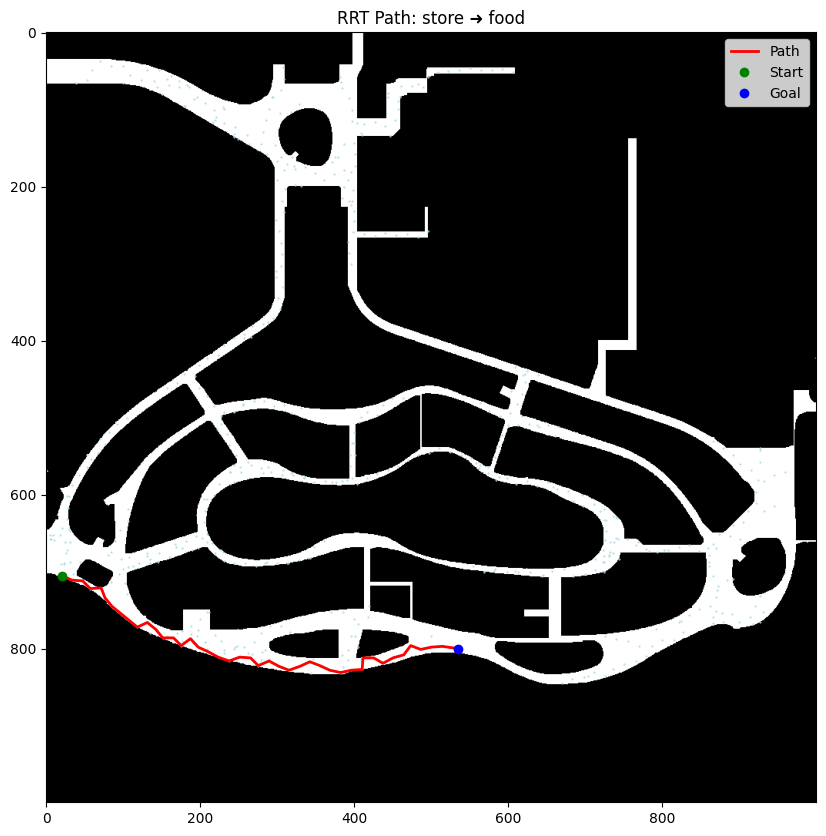

<Figure size 640x480 with 0 Axes>


Planning path: movie ➜ food
Path found! Distance: 127.62 m, Time: 0.3515 s
Visited nodes: 118


<Figure size 640x480 with 0 Axes>

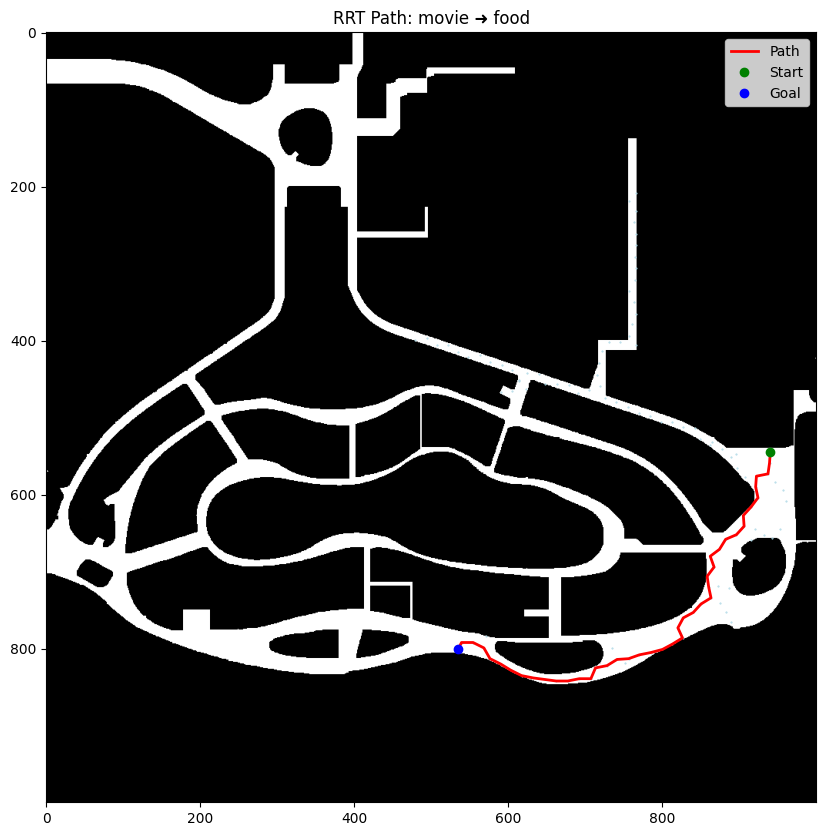

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [34]:
from itertools import combinations        # Used to generate all unique unordered location pairs
from IPython.display import display       # Allows inline display of plots within Jupyter Notebooks

# Initialize a dictionary to store the pairwise distances computed by RRT
# The keys are (loc1, loc2) tuples, and the values will be distances in meters
rrt_distance_table = {}

# Inform the user that the planning loop is starting
print("Running RRT planning for all location pairs...\n")

# Loop over all unique unordered location pairs using combinations
# This avoids redundant calculations such as both (A, B) and (B, A)
for loc1, loc2 in combinations(location_names, 2):
    
    # Retrieve the pixel coordinates of the start and goal locations
    start = locations[loc1]
    goal = locations[loc2]

    # Log which pair is currently being planned
    print(f"\nPlanning path: {loc1} ➜ {loc2}")

    # Execute a single RRT attempt to find a path between start and goal
    # Parameters include step size, max iterations, and how close to the goal is considered "success"
    path, distance, visited, runtime = rrt(
        inflated_grid_map,
        start,
        goal,
        step_size=15,      # The incremental step length for RRT expansion (in pixels)
        max_iter=10000,    # Maximum number of nodes that can be sampled during the search
        goal_threshold=20  # The radius within which the path is considered to have reached the goal
    )

    # === Handle Planning Outcome ===
    if len(path) <= 1:
        # If the returned path is empty or too short, treat this as a failure
        print(f"Failed to find path: {loc1} ➜ {loc2}")
        distance = float('inf')  # Use infinity to represent an unreachable path

    else:
        # If a valid path is returned, print its statistics
        print(f"Path found! Distance: {distance:.2f} m, Time: {runtime:.4f} s")
        print(f"Visited nodes: {len(visited)}")
        rrt_runtime_dict[(loc1, loc2)] = runtime
        rrt_visited_dict[(loc1, loc2)] = len(visited)

        rrt_runtime_dict[(loc2, loc1)] = runtime
        rrt_visited_dict[(loc2, loc1)] = len(visited)



        # Visualize the path on the inflated grid map
        plot_path_on_map(
            inflated_grid_map,
            path,
            visited=visited,          # Optional: show explored nodes
            start=start,
            goal=goal,
            title=f"RRT Path: {loc1} ➜ {loc2}"
        )

        # Force the plot to be displayed immediately in notebook (important inside loops)
        display(plt.gcf())

    # Record the computed distance for both (loc1, loc2) and (loc2, loc1)
    # This ensures the table is symmetric and usable for TSP or distance matrix
    rrt_distance_table[(loc1, loc2)] = distance
    rrt_distance_table[(loc2, loc1)] = distance


In [12]:
# Define a Greedy Best-First Search (GBFS) algorithm for grid-based path planning.
# This algorithm uses only the heuristic distance (h(n)) to the goal when choosing nodes.
# It is faster than A* but does not guarantee the shortest path.

def greedy_best_first(grid, start, goal):
    import heapq   # Provides a min-heap priority queue used for the open set
    import time    # Used to measure the runtime duration of the algorithm

    # Record the start time to compute how long the algorithm takes
    start_time = time.time()

    # Convert (x, y) coordinates to (y, x) to match grid indexing (row-major)
    start = tuple(reversed(start))
    goal = tuple(reversed(goal))

    # === Initialization ===

    # Priority queue (open set) stores tuples of (heuristic value, node)
    # Since GBFS only uses heuristic, we initialize with h(start, goal)
    open_set = []
    heapq.heappush(open_set, (heuristic(start, goal), start))

    # Dictionary to store the path (i.e., backpointer for each node)
    came_from = {}

    # Set to track which nodes have been visited (to avoid revisiting them)
    visited = set()

    # === Main Loop ===
    while open_set:
        # Pop the node with the lowest heuristic value from the open set
        _, current = heapq.heappop(open_set)
        visited.add(current)

        # If the goal is reached, exit the loop
        if current == goal:
            break

        # Explore all valid neighbors of the current node
        for neighbor, _ in get_neighbors(current, grid):
            # Only consider neighbors that haven’t been visited or queued
            if neighbor not in visited and neighbor not in came_from:
                # Push neighbor into the open set using its heuristic distance to the goal
                heapq.heappush(open_set, (heuristic(neighbor, goal), neighbor))
                came_from[neighbor] = current


    # === Path Reconstruction ===

    # Reconstruct the path by tracing back from the goal to the start using the came_from dictionary
    path = []
    current = goal
    while current != start:
        path.append(current)
        # If current is not in came_from, .get() will return start, avoiding infinite loop
        current = came_from.get(current, start)
    path.append(start)
    path.reverse()  # Final path must go from start → goal


    # === Path Distance Calculation ===

    # Initialize total distance (in pixels)
    total_distance = 0

    # Iterate over each consecutive segment in the path
    for i in range(1, len(path)):
        dx = abs(path[i][0] - path[i-1][0])
        dy = abs(path[i][1] - path[i-1][1])

        # If the move is diagonal, use distance ~0.282 (Euclidean diagonal on grid)
        # If straight (vertical/horizontal), use 0.2
        total_distance += 0.282 if dx == 1 and dy == 1 else 0.2

    # Convert from pixels to meters using map resolution
    total_distance *= MAP_RES

    # Measure total runtime
    runtime = time.time() - start_time

    # Return the results:
    # - path: list of (y, x) coordinates from start to goal
    # - total_distance: length of the path in meters
    # - visited: nodes explored during the search (for visualization)
    # - runtime: time taken to find the path (in seconds)
    return path, total_distance, visited, runtime


Running Greedy Best-First Search for all location pairs...


Greedy Path: start ➜ snacks
Total Distance: 29.25 m
Visited Cells: 3815
Runtime: 0.0848 s


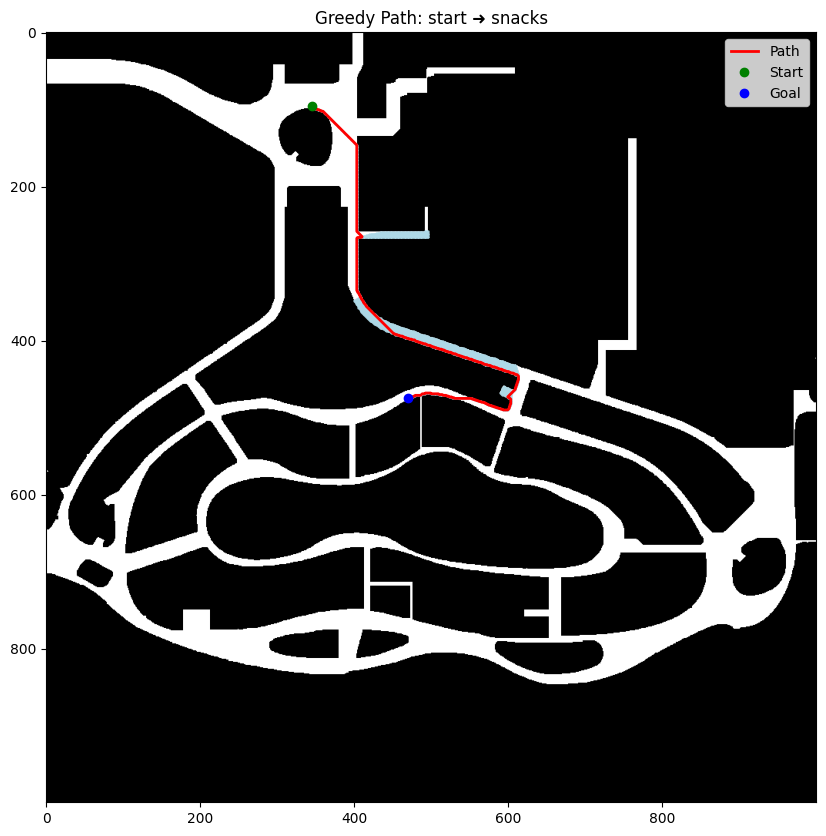

<Figure size 640x480 with 0 Axes>


Greedy Path: start ➜ store
Total Distance: 32.15 m
Visited Cells: 677
Runtime: 0.0264 s


<Figure size 640x480 with 0 Axes>

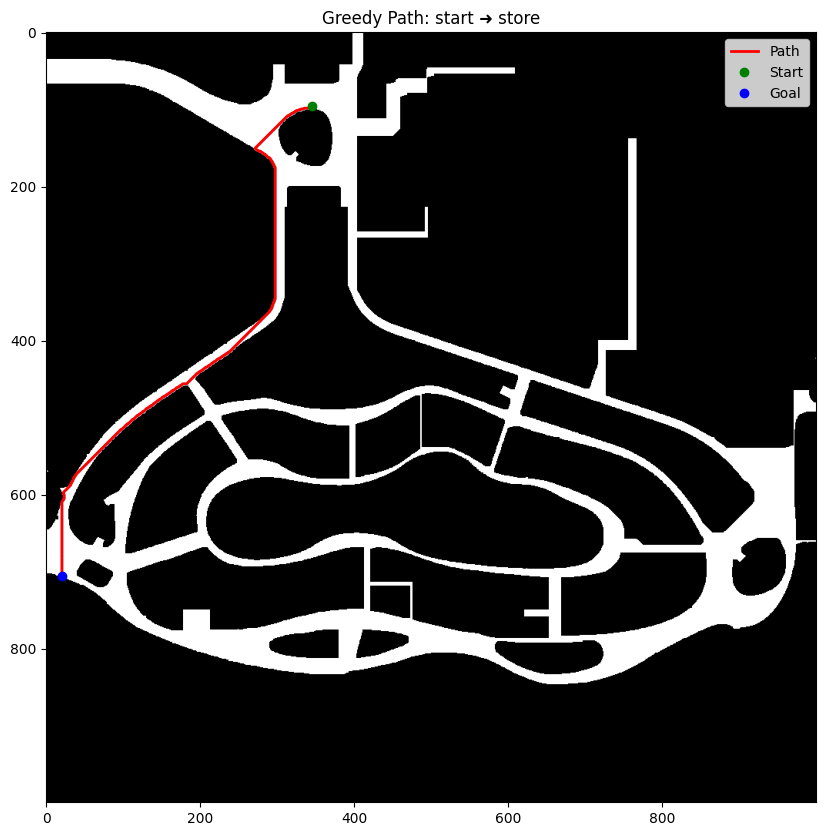

<Figure size 640x480 with 0 Axes>


Greedy Path: start ➜ movie
Total Distance: 36.48 m
Visited Cells: 1651
Runtime: 0.0391 s


<Figure size 640x480 with 0 Axes>

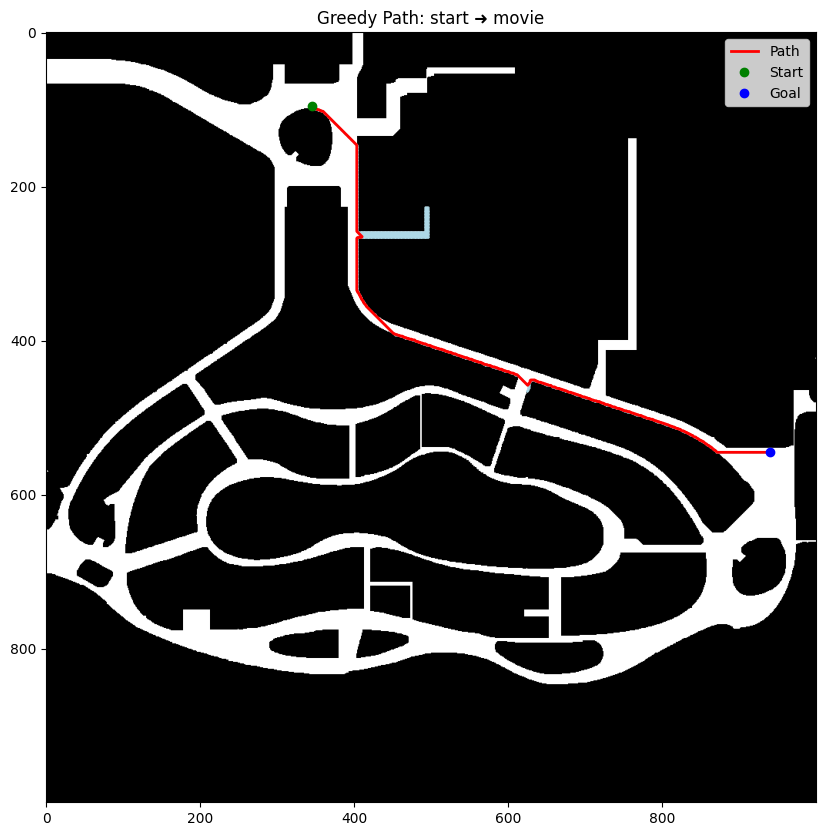

<Figure size 640x480 with 0 Axes>


Greedy Path: start ➜ food
Total Distance: 47.97 m
Visited Cells: 3460
Runtime: 0.0739 s


<Figure size 640x480 with 0 Axes>

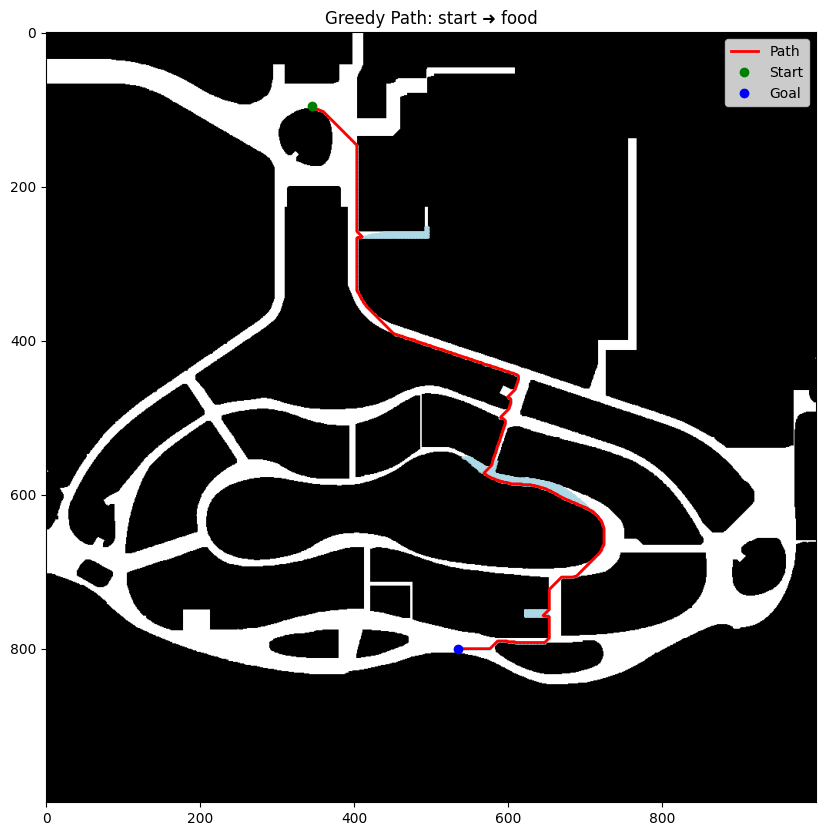

<Figure size 640x480 with 0 Axes>


Greedy Path: snacks ➜ store
Total Distance: 24.89 m
Visited Cells: 545
Runtime: 0.0199 s


<Figure size 640x480 with 0 Axes>

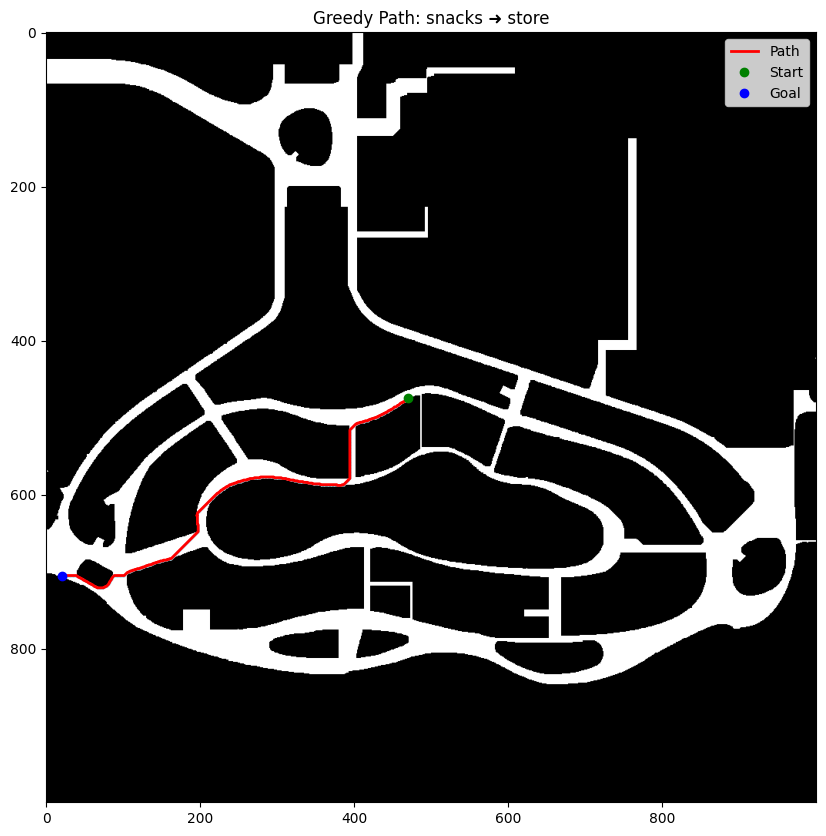

<Figure size 640x480 with 0 Axes>


Greedy Path: snacks ➜ movie
Total Distance: 28.89 m
Visited Cells: 843
Runtime: 0.0178 s


<Figure size 640x480 with 0 Axes>

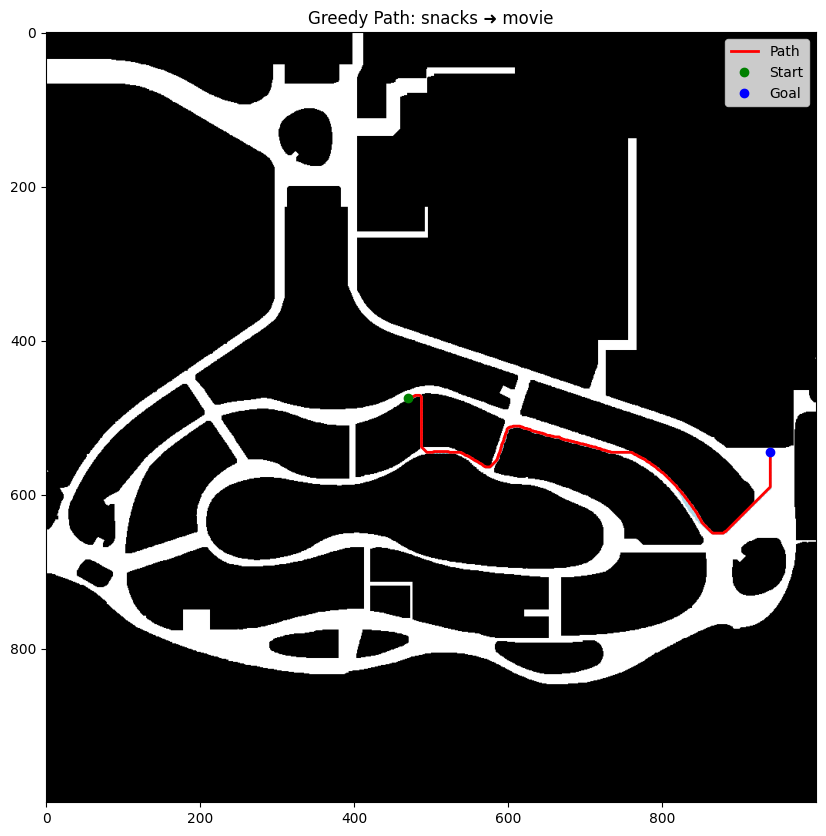

<Figure size 640x480 with 0 Axes>


Greedy Path: snacks ➜ food
Total Distance: 34.35 m
Visited Cells: 3096
Runtime: 0.0794 s


<Figure size 640x480 with 0 Axes>

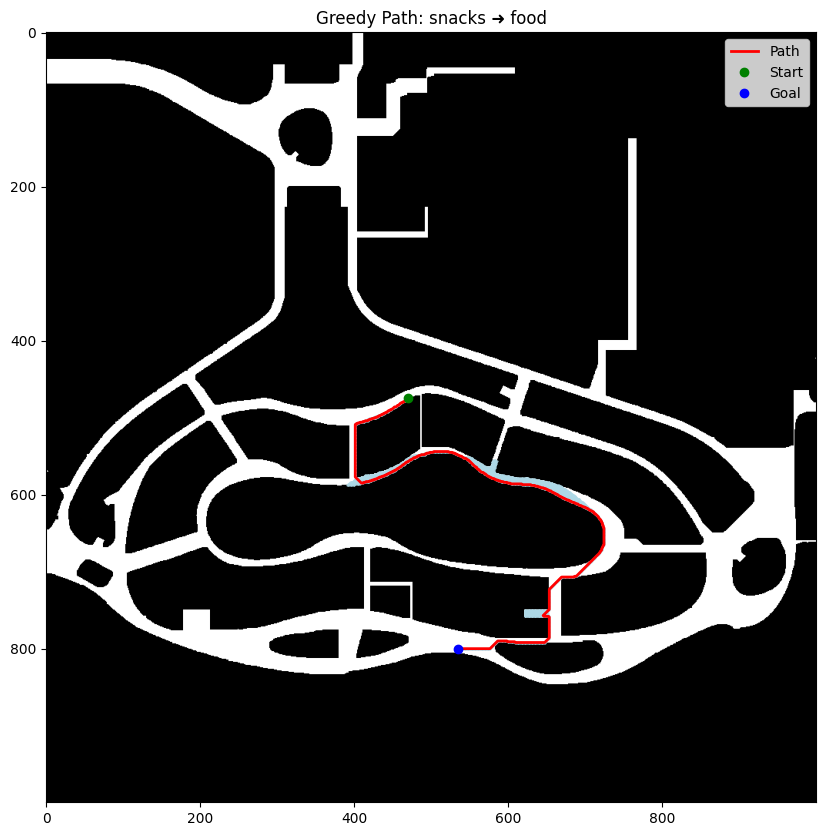

<Figure size 640x480 with 0 Axes>


Greedy Path: store ➜ movie
Total Distance: 51.41 m
Visited Cells: 1364
Runtime: 0.0645 s


<Figure size 640x480 with 0 Axes>

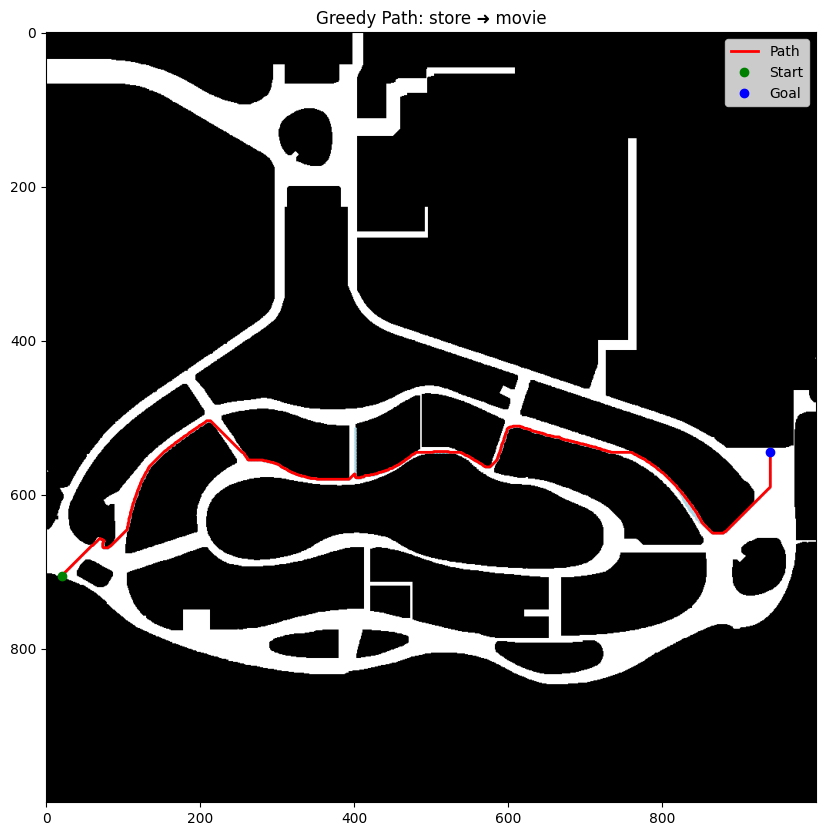

<Figure size 640x480 with 0 Axes>


Greedy Path: store ➜ food
Total Distance: 23.81 m
Visited Cells: 536
Runtime: 0.0218 s


<Figure size 640x480 with 0 Axes>

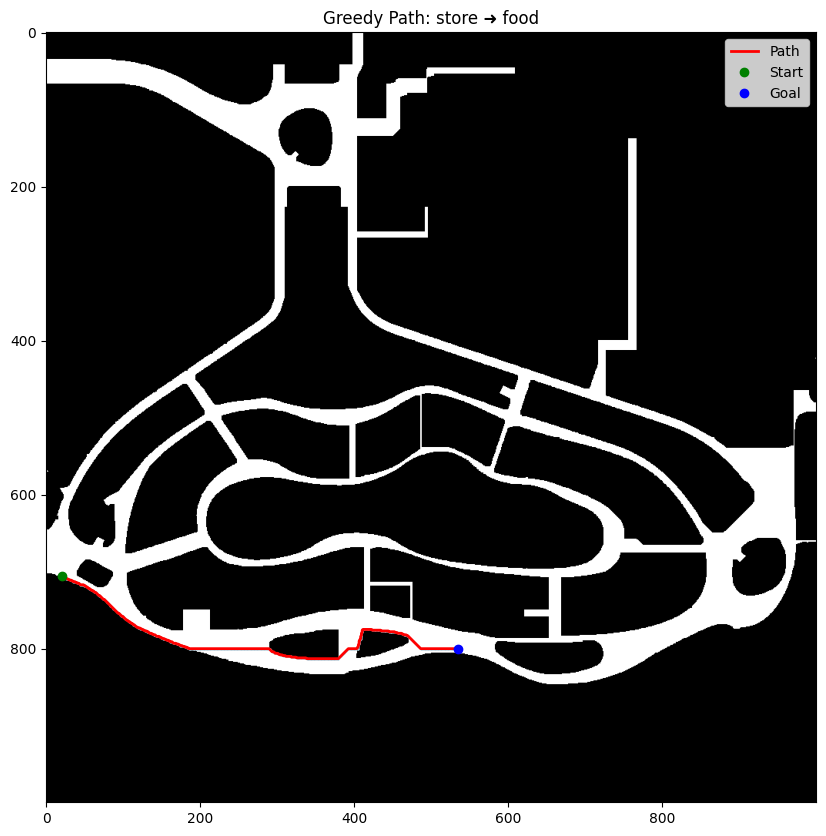

<Figure size 640x480 with 0 Axes>


Greedy Path: movie ➜ food
Total Distance: 41.61 m
Visited Cells: 2686
Runtime: 0.0872 s


<Figure size 640x480 with 0 Axes>

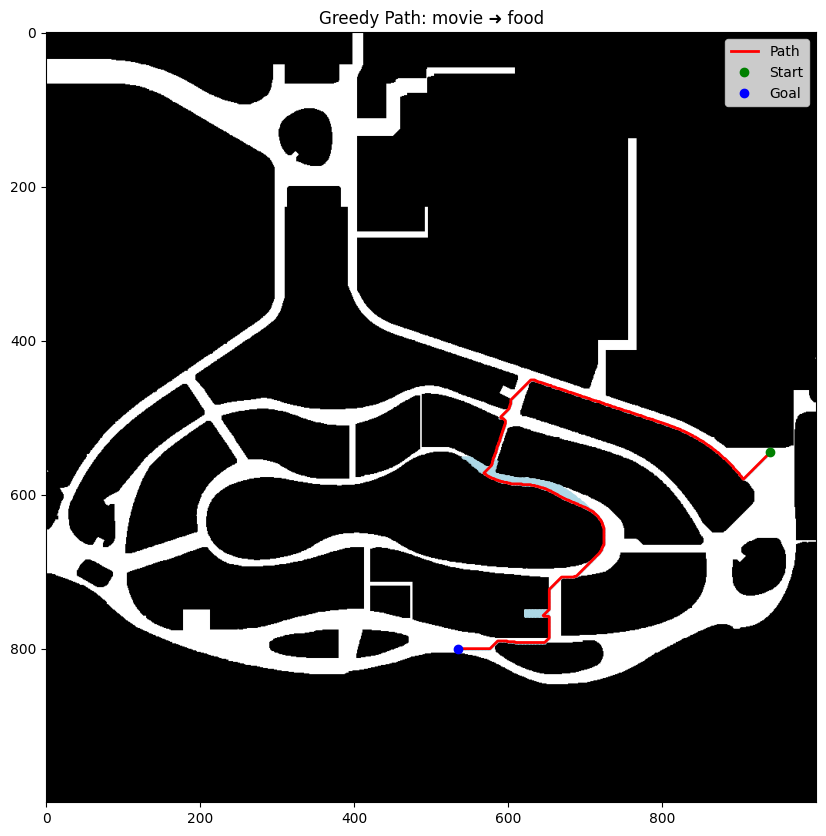

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [36]:
from itertools import combinations           # Used to generate all unordered location pairs (no repeats)
from IPython.display import display          # Ensures individual plots display inline in Jupyter


# Initialize a dictionary to store the distances computed by Greedy Best-First Search
# Keys will be (loc1, loc2) tuples, values will be the corresponding path distances (in meters)
greedy_distance_table = {}

# Print a header indicating the Greedy search process is starting
print("Running Greedy Best-First Search for all location pairs...\n")

greedy_runtime_dict = {}
greedy_visited_dict = {}

# Iterate through all unique unordered pairs of locations (e.g., ('start', 'store'), etc.)
for loc1, loc2 in combinations(location_names, 2):
    
    # Retrieve the (x, y) coordinates of both locations from the predefined dictionary
    start = locations[loc1]
    goal = locations[loc2]

    # Log the current pair being processed
    print(f"\nGreedy Path: {loc1} ➜ {loc2}")
    
    # Execute Greedy Best-First Search to compute a path from start to goal
    # Outputs:
    # - path: list of waypoints (y, x) from start to goal
    # - distance: total path length in meters
    # - visited: set of explored nodes (for visualization)
    # - runtime: time taken in seconds
    path, distance, visited, runtime = greedy_best_first(inflated_grid_map, start, goal)
    greedy_runtime_dict[(loc1, loc2)] = runtime
    greedy_visited_dict[(loc1, loc2)] = len(visited)
    greedy_runtime_dict[(loc2, loc1)] = runtime
    greedy_visited_dict[(loc2, loc1)] = len(visited)


    # Store the computed distance in the lookup table for both directions (symmetry)
    greedy_distance_table[(loc1, loc2)] = distance
    greedy_distance_table[(loc2, loc1)] = distance


    # Print out useful summary statistics for this route
    print(f"Total Distance: {distance:.2f} m")
    print(f"Visited Cells: {len(visited)}")
    print(f"Runtime: {runtime:.4f} s")


    # Plot the path using the same visualization function as A*
    # This includes: path line, visited cells, start and goal markers
    plot_path_on_map(
        inflated_grid_map,
        path,
        visited,
        start=start,
        goal=goal,
        title=f"Greedy Path: {loc1} ➜ {loc2}"
    )

    # Force immediate plot display (important in loops to avoid figure overwrite)
    display(plt.gcf())


In [14]:
import pandas as pd 
# Initialize a square pandas DataFrame to store the distance matrix
# - Rows and columns are labeled by the names of the locations (e.g., 'start', 'store', etc.)
# - All initial values are set to 0.0
# This structure makes it easy to compare pairwise distances visually or use in TSP algorithms.
greedy_matrix = pd.DataFrame(0.0, index=location_names, columns=location_names)


# Loop through all entries in the greedy_distance_table
# Each entry represents the distance from loc1 to loc2
for (loc1, loc2), dist in greedy_distance_table.items():
    
    # Insert the distance value into the matrix
    # This populates the cell at row 'loc1' and column 'loc2'
    # Round the value to 2 decimal places for readability
    greedy_matrix.loc[loc1, loc2] = round(dist, 2)

distance_matrix = pd.DataFrame(0.0, index=location_names, columns=location_names)

for (loc1, loc2), dist in distance_table.items():
    distance_matrix.loc[loc1, loc2] = round(dist, 2)

# Create a square DataFrame to represent pairwise distances from RRT results.
# - Rows and columns correspond to location names (e.g., 'start', 'store', etc.)
# - All initial values are set to 0.0
# This matrix will be filled using the values from rrt_distance_table.
rrt_matrix = pd.DataFrame(0.0, index=location_names, columns=location_names)


# Loop through each entry in the RRT distance table dictionary.
# Keys are location pairs (loc1, loc2), and values are distances in meters.
for (loc1, loc2), dist in rrt_distance_table.items():

    # If the distance is not infinite, round it and insert into the matrix.
    # If the distance is infinite (i.e., RRT failed to find a path), store None instead.
    # None is visually cleaner than "inf" and will appear as blank in the DataFrame.
    rrt_matrix.loc[loc1, loc2] = round(dist, 2) if dist != float('inf') else None



In [41]:
# === Convert to pandas DataFrame for better presentation ===
comparison_df_all = pd.DataFrame(comparison_all)

# Sort results by RRT error (descending), so worst cases appear first
comparison_df_all = comparison_df_all.sort_values(by="RRT Error (%)", ascending=False)

# === Display the comparison table ===
print(" Path Distance Comparison (A* vs Greedy vs RRT)")
display(comparison_df_all)

# === Step 1: Output average path lengths for each algorithm ===
avg_astar_dist = comparison_df_all["A* (m)"].mean()
avg_greedy_dist = comparison_df_all["Greedy (m)"].mean()
avg_rrt_dist = comparison_df_all["RRT (m)"].mean()

print("\n Average Path Lengths")
print(f"- A*     Avg: {avg_astar_dist:.2f} m")
print(f"- Greedy Avg: {avg_greedy_dist:.2f} m")
print(f"- RRT    Avg: {avg_rrt_dist:.2f} m")

# === Step 2: Output average absolute and relative errors (vs A*) ===
avg_greedy_delta = comparison_df_all["Greedy Δ (m)"].mean()
avg_rrt_delta = comparison_df_all["RRT Δ (m)"].mean()

avg_greedy_error = comparison_df_all["Greedy Error (%)"].mean()
avg_rrt_error = comparison_df_all["RRT Error (%)"].mean()

print("\n Average Distance Difference & Error (relative to A*)")
print(f"- Greedy Δ: {avg_greedy_delta:.2f} m | Error: {avg_greedy_error:.2f} %")
print(f"- RRT    Δ: {avg_rrt_delta:.2f} m | Error: {avg_rrt_error:.2f} %")


 Path Distance Comparison (A* vs Greedy vs RRT)


,From,To,A* (m),Greedy (m),RRT (m),Greedy Δ (m),RRT Δ (m),Greedy Error (%),RRT Error (%)
1,start,store,32.04,32.15,384.69,0.11,352.65,0.34,1100.66
7,store,start,32.04,32.15,384.69,0.11,352.65,0.34,1100.66
15,food,snacks,27.14,34.35,229.14,7.21,202.00,26.57,744.29
6,snacks,food,27.14,34.35,229.14,7.21,202.00,26.57,744.29
14,food,start,46.72,47.97,300.60,1.25,253.88,2.68,543.41
3,start,food,46.72,47.97,300.60,1.25,253.88,2.68,543.41
9,store,food,23.04,23.81,138.77,0.77,115.73,3.34,502.30
16,food,store,23.04,23.81,138.77,0.77,115.73,3.34,502.30
11,movie,snacks,25.07,28.89,146.21,3.82,121.14,15.24,483.21
5,snacks,movie,25.07,28.89,146.21,3.82,121.14,15.24,483.21



 Average Path Lengths
- A*     Avg: 34.55 m
- Greedy Avg: 36.21 m
- RRT    Avg: 213.81 m

 Average Distance Difference & Error (relative to A*)
- Greedy Δ: 1.67 m | Error: 5.90 %
- RRT    Δ: 179.26 m | Error: 537.46 %


In [42]:
# === Initialize comparison list ===
timing_comparison = []

# Loop over every valid path pair from the previous comparison
for row in comparison_df_all.itertuples():
    loc1 = row.From
    loc2 = row.To

    # Retrieve runtime and visited counts
    a_time = a_star_runtime_dict.get((loc1, loc2), None)
    rrt_time = rrt_runtime_dict.get((loc1, loc2), None)
    greedy_time = greedy_runtime_dict.get((loc1, loc2), None)

    a_visited = a_star_visited_dict.get((loc1, loc2), None)
    rrt_visited = rrt_visited_dict.get((loc1, loc2), None)
    greedy_visited = greedy_visited_dict.get((loc1, loc2), None)

    # Skip incomplete records (you can relax condition if needed)
    if None in [a_time, rrt_time, greedy_time]:
        continue

    timing_comparison.append({
        "From": loc1,
        "To": loc2,

        "A* Time (s)": round(a_time, 4),
        "Greedy Time (s)": round(greedy_time, 4),
        "RRT Time (s)": round(rrt_time, 4),

        "A* Visited": a_visited,
        "Greedy Visited": greedy_visited,
        "RRT Visited": rrt_visited,

        "Time Ratio (Greedy/A*)": round(greedy_time / a_time, 2) if a_time > 0 else None,
        "Time Ratio (RRT/A*)": round(rrt_time / a_time, 2) if a_time > 0 else None,

        "Visited Ratio (Greedy/A*)": round(greedy_visited / a_visited, 2) if a_visited else None,
        "Visited Ratio (RRT/A*)": round(rrt_visited / a_visited, 2) if a_visited else None,
    })

# Convert to DataFrame
timing_df = pd.DataFrame(timing_comparison)

# Optional: sort by worst-case (choose one ratio column)
timing_df = timing_df.sort_values(by="Time Ratio (RRT/A*)", ascending=False)

print("⏱️ Time & Visited Node Comparison (A* vs Greedy vs RRT)")
display(timing_df)

# === Compute average values ===
avg_astar_time = timing_df["A* Time (s)"].mean()
avg_greedy_time = timing_df["Greedy Time (s)"].mean()
avg_rrt_time = timing_df["RRT Time (s)"].mean()

avg_astar_visited = timing_df["A* Visited"].mean()
avg_greedy_visited = timing_df["Greedy Visited"].mean()
avg_rrt_visited = timing_df["RRT Visited"].mean()

avg_greedy_time_ratio = timing_df["Time Ratio (Greedy/A*)"].mean()
avg_rrt_time_ratio = timing_df["Time Ratio (RRT/A*)"].mean()
avg_greedy_visited_ratio = timing_df["Visited Ratio (Greedy/A*)"].mean()
avg_rrt_visited_ratio = timing_df["Visited Ratio (RRT/A*)"].mean()

# === Print average comparison summary ===
print("Average Performance Comparison")
print(f"- A*  Avg Time: {avg_astar_time:.4f}s | Avg Visited: {avg_astar_visited:.1f}")
print(f"- Greedy Avg Time: {avg_greedy_time:.4f}s | Avg Visited: {avg_greedy_visited:.1f}")
print(f"- RRT    Avg Time: {avg_rrt_time:.4f}s | Avg Visited: {avg_rrt_visited:.1f}")
print()
print(f"Greedy Time Ratio (vs A*): {avg_greedy_time_ratio:.2f}")
print(f"RRT Time Ratio    (vs A*): {avg_rrt_time_ratio:.2f}")
print(f"Greedy Visited Ratio (vs A*): {avg_greedy_visited_ratio:.2f}")
print(f"RRT Visited Ratio    (vs A*): {avg_rrt_visited_ratio:.2f}")
print("Average Visited Nodes (Explored Grid Cells)")
print(f"- A*     Avg Visited Nodes: {avg_astar_visited:.1f}")
print(f"- Greedy Avg Visited Nodes: {avg_greedy_visited:.1f}")
print(f"- RRT    Avg Visited Nodes: {avg_rrt_visited:.1f}")



⏱️ Time & Visited Node Comparison (A* vs Greedy vs RRT)


,From,To,A* Time (s),Greedy Time (s),RRT Time (s),A* Visited,Greedy Visited,RRT Visited,Time Ratio (Greedy/A*),Time Ratio (RRT/A*),Visited Ratio (Greedy/A*),Visited Ratio (RRT/A*)
6,store,food,0.0189,0.0218,9.2592,541,536,580,1.15,489.78,0.99,1.07
7,food,store,0.0189,0.0218,9.2592,541,536,580,1.15,489.78,0.99,1.07
1,store,start,0.0288,0.0264,13.8701,695,677,590,0.92,480.87,0.97,0.85
0,start,store,0.0288,0.0264,13.8701,695,677,590,0.92,480.87,0.97,0.85
12,start,snacks,0.2613,0.0848,55.6964,4074,3815,1191,0.32,213.13,0.94,0.29
13,snacks,start,0.2613,0.0848,55.6964,4074,3815,1191,0.32,213.13,0.94,0.29
10,start,movie,0.1535,0.0391,19.0780,1659,1651,728,0.25,124.27,1.00,0.44
11,movie,start,0.1535,0.0391,19.0780,1659,1651,728,0.25,124.27,1.00,0.44
15,movie,store,0.0900,0.0645,1.8919,1903,1364,286,0.72,21.01,0.72,0.15
14,store,movie,0.0900,0.0645,1.8919,1903,1364,286,0.72,21.01,0.72,0.15


Average Performance Comparison
- A*  Avg Time: 0.2251s | Avg Visited: 2747.3
- Greedy Avg Time: 0.0550s | Avg Visited: 2014.2
- RRT    Avg Time: 12.3359s | Avg Visited: 479.8

Greedy Time Ratio (vs A*): 0.45
RRT Time Ratio    (vs A*): 150.99
Greedy Visited Ratio (vs A*): 0.80
RRT Visited Ratio    (vs A*): 0.34
Average Visited Nodes (Explored Grid Cells)
- A*     Avg Visited Nodes: 2747.3
- Greedy Avg Visited Nodes: 2014.2
- RRT    Avg Visited Nodes: 479.8


## Task 2

In [45]:
import time  # Add this at the top if not already imported
start_time = time.time()  # Start timing

from itertools import permutations  # Import permutations to enumerate all possible visit orders

# Define the intermediate locations that need to be visited (excluding the starting point)
visit_points = ['snacks', 'store', 'movie', 'food']

# Define the name of the starting (and ending) location
start_point = 'start'

# This list will eventually contain the best (shortest) path found among all permutations
best_path = []

# This variable stores the minimum total travel distance found so far; initialized to infinity
# so that any valid path distance will be smaller and will replace it
min_total_distance = float('inf')

# This list stores the segment-by-segment distances of the best path, for reporting purposes
best_path_distances = []

# Try every possible order in which to visit the intermediate points
# Since the total number of intermediate points is small (4), this exhaustive search is acceptable
for perm in permutations(visit_points):
    
    # Construct a full round-trip route by adding the start point at the beginning and end
    # The robot starts at the start point, visits all the points in the permutation order, and returns
    route = [start_point] + list(perm) + [start_point]

    # Initialize the total distance accumulator for this particular route
    total_dist = 0

    # This list will store the distances between each consecutive pair in the current route
    segment_distances = []

    # Evaluate the total distance for the current route
    for i in range(len(route) - 1):
        from_loc = route[i]        # The current location
        to_loc = route[i + 1]      # The next location in the route

        # Use the precomputed A* distance matrix to get the distance between the two locations
        dist = distance_matrix.loc[from_loc, to_loc]

        # Add this segment distance to the total route distance
        total_dist += dist

        # Store the segment details for reporting later
        segment_distances.append((from_loc, to_loc, round(dist, 2)))

    # If the current route has a shorter total distance than the best found so far,
    # then update the best path and its associated distance details
    if total_dist < min_total_distance:
        min_total_distance = total_dist
        best_path = route
        best_path_distances = segment_distances


# Output the best route found across all permutations
print("Task 2 Optimal Route (Brute Force TSP):")
print("Visiting Order :", " → ".join(best_path))  # Show the ordered sequence of locations

# Output the total travel distance of the optimal path
print(f"Total Distance : {min_total_distance:.2f} m")

# Output the distance for each segment of the path
print("\nSegment Distances (in meters):")
for frm, to, d in best_path_distances:
    print(f"{frm} ➜ {to} : {d:.2f} m")
end_time = time.time()
elapsed_time = end_time - start_time
print(f"\n Computation Time: {elapsed_time:.4f} seconds")

Task 2 Optimal Route (Brute Force TSP):
Visiting Order : start → movie → snacks → food → store → start
Total Distance : 143.43 m

Segment Distances (in meters):
start ➜ movie : 36.14 m
movie ➜ snacks : 25.07 m
snacks ➜ food : 27.14 m
food ➜ store : 23.04 m
store ➜ start : 32.04 m

 Computation Time: 0.0126 seconds


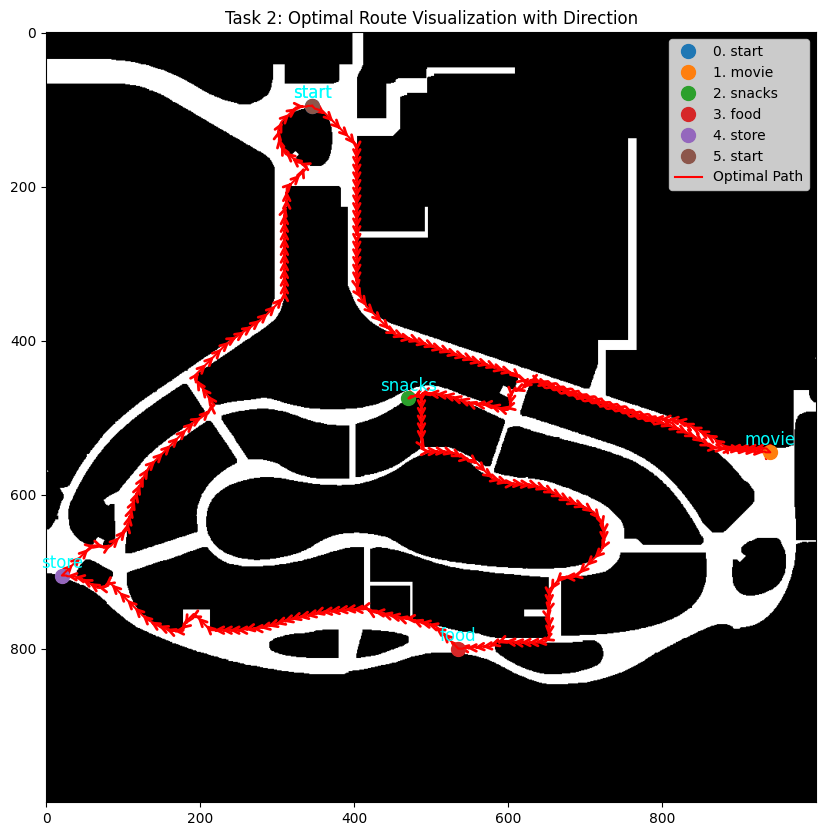

In [17]:
from matplotlib.patches import FancyArrowPatch

# === Step 1: Build full pixel-level path based on best_path using A* ===
full_path = []

# Loop through each segment of the best route and use A* to get pixel-level sub-paths
for i in range(len(best_path) - 1):
    from_loc = best_path[i]
    to_loc = best_path[i + 1]

    # Get pixel coordinates of the start and end locations
    start = locations[from_loc]
    goal = locations[to_loc]

    # Compute path between the two points using A* (should already be defined)
    path_segment, _, _, _ = astar(inflated_grid_map, start, goal)

    # To avoid duplicate points, skip the first point of every segment after the first
    if i > 0:
        path_segment = path_segment[1:]

    # Append this segment to the full path
    full_path.extend(path_segment)


# === Step 2: Plot the full path on the map with directional arrows ===
plt.figure(figsize=(10, 10))
plt.imshow(inflated_grid_map, cmap='gray')

# Plot and label each named location in the path
for idx, name in enumerate(best_path):
    x, y = locations[name]
    plt.plot(x, y, 'o', markersize=10, label=f"{idx}. {name}")
    plt.text(x, y - 10, name, fontsize=12, ha='center', color='cyan')

# Convert full path to NumPy array for plotting
path_np = np.array(full_path)

# Draw the full path as a red line
plt.plot(path_np[:, 1], path_np[:, 0], 'r-', linewidth=1.5, label='Optimal Path')

# Plot sparse directional arrows along the path to indicate travel direction
arrow_interval = 10  # One arrow every 10 points
for i in range(0, len(path_np) - arrow_interval, arrow_interval):
    y0, x0 = path_np[i]
    y1, x1 = path_np[i + arrow_interval]

    arrow = FancyArrowPatch(
        (x0, y0), (x1, y1),
        arrowstyle='->',
        color='red',
        linewidth=2,
        mutation_scale=12
    )
    plt.gca().add_patch(arrow)

# Add legend and title
plt.legend()
plt.title("Task 2: Optimal Route Visualization with Direction")
plt.show()


In [46]:
import time  

start_time = time.time()  

from itertools import combinations  # Used to enumerate subsets of visited nodes

# Define the full list of locations including the start point
all_points = ['start', 'snacks', 'store', 'movie', 'food']

# Create a mapping from location name to index (e.g., 'start' -> 0)
point_idx = {name: i for i, name in enumerate(all_points)}

# Create a reverse mapping from index to location name (e.g., 0 -> 'start')
idx_point = {i: name for name, i in point_idx.items()}

# Total number of nodes in the TSP problem
n = len(all_points)


# === Step 1: Build the distance matrix ===
# Initialize a 2D NumPy array to store the pairwise distances between locations
# Distance values are taken from the precomputed A* distance matrix
dist_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if i != j:
            dist_matrix[i][j] = distance_matrix.loc[all_points[i], all_points[j]]


# === Step 2: Initialize the DP table and path tracker ===
# dp[(subset_bitmask, last_node)] = minimum cost to reach `last_node` via `subset`
# path_record[(subset_bitmask, last_node)] = previous node before `last_node`
dp = {}
path_record = {}

# Initialize base cases:
# For all points except the start (index 0), compute the cost of reaching them directly from the start
for k in range(1, n):  # Only visiting from the start to other nodes
    dp[(1 << k, k)] = dist_matrix[0][k]
    path_record[(1 << k, k)] = 0


# === Step 3: Dynamic Programming State Transitions ===
# Build up the DP table for subsets of increasing size
# subset_size is the number of visited nodes (excluding start)
for subset_size in range(2, n):
    for subset in combinations(range(1, n), subset_size):
        # Convert subset to bitmask representation
        bits = sum(1 << x for x in subset)

        # Try ending at each node k in this subset
        for k in subset:
            # Remove k from the subset to get the previous state
            prev_bits = bits & ~(1 << k)

            min_dist = float('inf')  # Track the best cost to reach k
            prev_node = -1           # Track which node led to the best cost

            # Try all possible previous nodes m in the subset (excluding k)
            for m in subset:
                if m == k:
                    continue
                if (prev_bits, m) in dp:
                    new_dist = dp[(prev_bits, m)] + dist_matrix[m][k]
                    if new_dist < min_dist:
                        min_dist = new_dist
                        prev_node = m

            # Store the minimum cost and its predecessor
            dp[(bits, k)] = min_dist
            path_record[(bits, k)] = prev_node


# === Step 4: Complete the cycle (return to the start) ===
# Try all possible last nodes, and compute the cost of returning to the start (index 0)
full_bits = (1 << n) - 2  # Bitmask of all nodes except the start
min_cost = float('inf')   # Track overall minimum cycle cost
last_node = -1            # Track best last node before returning to start

for k in range(1, n):
    cost = dp[(full_bits, k)] + dist_matrix[k][0]
    if cost < min_cost:
        min_cost = cost
        last_node = k


# === Step 5: Backtrack to recover the optimal visiting order ===
order = []
bits = full_bits
current = last_node

# Recover the path in reverse using the path_record
while current != 0:
    order.append(current)
    prev = path_record[(bits, current)]
    bits = bits & ~(1 << current)
    current = prev

# Add the starting node to the beginning of the path
order.append(0)
order.reverse()

# Convert the node indices back to location names
optimal_path_dp = [idx_point[i] for i in order] + ['start']  # Close the cycle by returning to start


# === Step 6: Print the final results ===

# Output the full optimal path visiting order
print("Held-Karp (DP) Optimal TSP Route:")
print("Visiting Order :", " → ".join(optimal_path_dp))

# Output the total cost (shortest tour distance)
print(f"Total Distance : {min_cost:.2f} m")

# Output segment-by-segment travel distances for detailed analysis
print("\nSegment Distances (in meters):")
for i in range(len(optimal_path_dp) - 1):
    p1 = optimal_path_dp[i]
    p2 = optimal_path_dp[i + 1]
    segment_dist = distance_matrix.loc[p1, p2]
    print(f"{p1} ➜ {p2} : {segment_dist:.2f} m")
end_time = time.time()  
elapsed_time = end_time - start_time
print(f"\n Held-Karp Computation Time: {elapsed_time:.4f} seconds")


Held-Karp (DP) Optimal TSP Route:
Visiting Order : start → movie → snacks → food → store → start
Total Distance : 143.43 m

Segment Distances (in meters):
start ➜ movie : 36.14 m
movie ➜ snacks : 25.07 m
snacks ➜ food : 27.14 m
food ➜ store : 23.04 m
store ➜ start : 32.04 m

 Held-Karp Computation Time: 0.0056 seconds


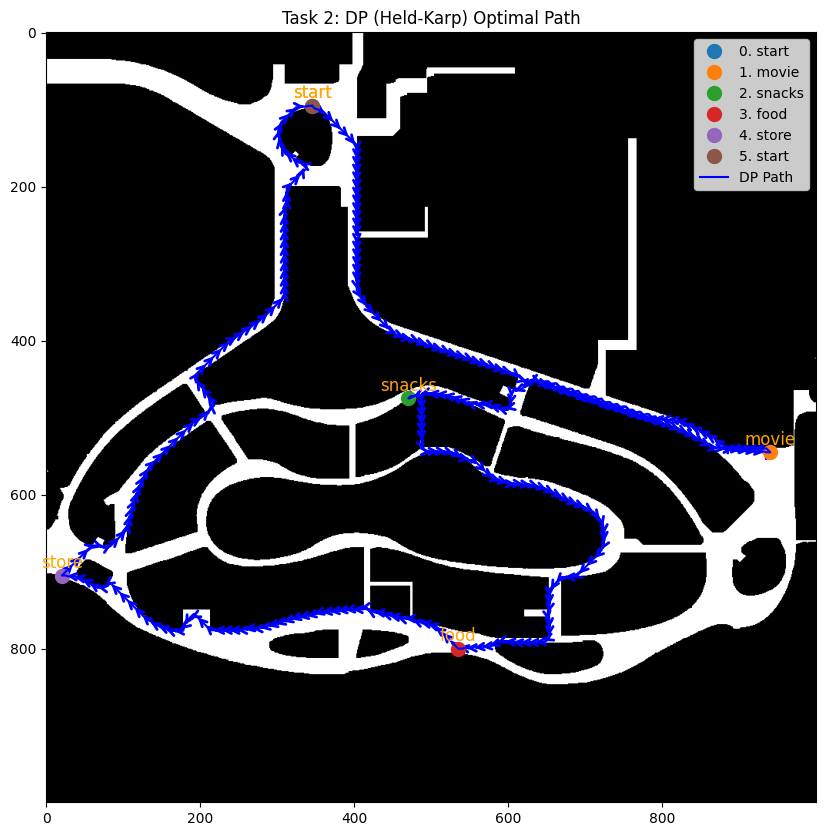

In [19]:
from matplotlib.patches import FancyArrowPatch  # Used to draw directional arrows along the path

# === Step 1: Generate the Full Pixel Path ===
# This list will contain all grid-level waypoints along the entire route
dp_full_path = []

# Loop through each segment in the optimal visiting order
for i in range(len(optimal_path_dp) - 1):
    name1 = optimal_path_dp[i]       # Current location name
    name2 = optimal_path_dp[i + 1]   # Next location name

    p1 = locations[name1]            # Pixel coordinate of current location
    p2 = locations[name2]            # Pixel coordinate of next location

    # Compute the shortest grid-based path between p1 and p2 using A* algorithm
    segment, _, _, _ = astar(inflated_grid_map, p1, p2)

    # To prevent duplicate nodes at segment junctions, remove the first point after the first segment
    if i > 0:
        segment = segment[1:]

    # Append this segment to the full route
    dp_full_path += segment


# === Step 2: Visualization of the Full Path on the Map ===

# Create a figure for plotting
plt.figure(figsize=(10, 10))

# Display the inflated grid map as background in grayscale
plt.imshow(inflated_grid_map, cmap='gray')


# === Plot the Visit Points on the Map ===
# Loop through all the waypoints in the optimal path and mark them
for idx, name in enumerate(optimal_path_dp):
    x, y = locations[name]  # Retrieve x, y pixel coordinates
    plt.plot(x, y, 'o', markersize=10, label=f"{idx}. {name}")  # Circle marker
    plt.text(x, y - 10, name, fontsize=12, ha='center', color='orange')  # Label with offset


# === Draw the Entire Path as a Blue Line ===
# Convert the list of (y, x) grid points into a NumPy array for vectorized plotting
path_np = np.array(dp_full_path)

# Plot the full route as a connected line
# Note that x = column index and y = row index in image coordinates
plt.plot(path_np[:, 1], path_np[:, 0], 'blue', linewidth=1.5, label='DP Path')


# === Add Directional Arrows Along the Path ===
arrow_interval = 10  # Draw one arrow every 10 points along the path

# Loop through the path with the defined interval and draw arrows
for i in range(0, len(path_np) - arrow_interval, arrow_interval):
    y0, x0 = path_np[i]
    y1, x1 = path_np[i + arrow_interval]

    # Create a directional arrow from (x0, y0) to (x1, y1)
    arrow = FancyArrowPatch(
        (x0, y0), (x1, y1),
        arrowstyle='->',
        color='blue',
        linewidth=2,
        mutation_scale=12  # Controls the size of the arrow head
    )

    # Add the arrow to the current plot
    plt.gca().add_patch(arrow)


# Add legend and plot title
plt.legend()
plt.title("Task 2: DP (Held-Karp) Optimal Path")

# Display the plot
plt.show()


## Task 3

In [ ]:
https://github.com/Ma-Romy/planning-project.git